## Analyze March 2022 Shearwater Cruise Data

In [46]:
import xarray as xr
import numpy as np

import hvplot.xarray


import cartopy.crs as crs

import pandas as pd
import geopandas as gpd

import glob
import hvplot.pandas  # noqa
from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

In [2]:
nav_df = pd.read_csv('data/march_cruise/SW22004R_NRL02/Navigation/SW-GGA_20220308-223656.Raw',  names=['Date', 'Time', 'GPGGA','Unknown', 'SW-GGA-Lat', 'latdir', 'SW-GGA-Long', 'londir', '1', '2', '3', '4', '5', '6', '7'])

def dms2dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes/60 + seconds/(60*60);
    if direction == 'W' or direction == 'S':
        dd *= -1
    return dd;

nav_df['lon'] = dms2dd(pd.to_numeric(nav_df['SW-GGA-Long'].astype(str).str[:2]).astype(float), pd.to_numeric(nav_df['SW-GGA-Long'].astype(str).str[2:]),np.array(0), 'W')
nav_df['lat'] = dms2dd(pd.to_numeric(nav_df['SW-GGA-Lat'].astype(str).str[:2]).astype(float), pd.to_numeric(nav_df['SW-GGA-Lat'].astype(str).str[2:]),np.array(0), 'E')

date_time_strs = nav_df['Date'] + ' ' + nav_df['Time']

nav_df['datetime'] = [datetime.strptime(x, '%m/%d/%Y %H:%M:%S.%f') for x in date_time_strs]
nav_df['utc_dt'] = nav_df['datetime']
nav_df  = nav_df.set_index('utc_dt')


tsg_df = pd.read_csv('data/march_cruise/SW22004R_NRL02/FlowThru/TSG-_20220308-223656.Raw', names=['DateTime', 'Temp','Sal','Unknown'], delim_whitespace=True)#sep=r"s*")# names=['Date', 'Time', 'Data'])
tsg_df['datetime'] = [datetime.strptime(x[:-1], '%m/%d/%Y,%H:%M:%S.%f') for x in tsg_df.DateTime]

chla_df = pd.read_csv('data/march_cruise/SW22004R_NRL02/FlowThru/FluorometerWETStar-Chlorophyll-DRV_20220308-223656.Raw', 
                      index_col=False,
                      names=['Date','Time','VarName','Chla','Volts'], sep=",")

chla_df['datetime'] = [datetime.strptime(x[:-1], '%m/%d/%Y%H:%M:%S.%f') for x in chla_df.Date+chla_df.Time]
chla_df['utc_dt'] = chla_df['datetime']
chla_df  = chla_df.set_index('utc_dt')

lats = []
lons = []
chla = []
for i in range(len(tsg_df)):
    row = nav_df.iloc[nav_df.index.get_loc(tsg_df.iloc[i].datetime, method='nearest')]
    lats.append(row.lat)
    lons.append(row.lon)
    row = chla_df.iloc[chla_df.index.get_loc(tsg_df.iloc[i].datetime, method='nearest')]
    chla.append(row.Chla)
    
tsg_df['lat'] = lats
tsg_df['lon'] = lons
tsg_df['chla'] = chla

tsg_df['utc_dt'] = tsg_df['datetime']
tsg_df  = tsg_df.set_index('utc_dt')

tsg_df = tsg_df.sort_index(ascending=True)

In [3]:
tsg_df.head()

DateTime     Temp      Sal  Unknown  \
utc_dt                                                                         
2022-03-09 00:36:05.508  03/09/2022,00:36:05.508,  16.2645  36.1202  1512.70   
2022-03-09 00:36:15.445  03/09/2022,00:36:15.445,  16.2730  36.1207  1512.73   
2022-03-09 00:36:25.440  03/09/2022,00:36:25.440,  16.2819  36.1212  1512.76   
2022-03-09 00:36:35.463  03/09/2022,00:36:35.463,  16.2967  36.1226  1512.80   
2022-03-09 00:36:45.437  03/09/2022,00:36:45.437,  16.3054  36.1229  1512.83   

                                       datetime        lat        lon  chla  
utc_dt                                                                       
2022-03-09 00:36:05.508 2022-03-09 00:36:05.508  34.544948 -76.605212  1.07  
2022-03-09 00:36:15.445 2022-03-09 00:36:15.445  34.544650 -76.604837  1.07  
2022-03-09 00:36:25.440 2022-03-09 00:36:25.440  34.544407 -76.604545  1.07  
2022-03-09 00:36:35.463 2022-03-09 00:36:35.463  34.544113 -76.604195  1.07  
2022-03-09 00:36:45.437 2022-03-09 00:36:45.437  34.543843 -76.603883  1.02

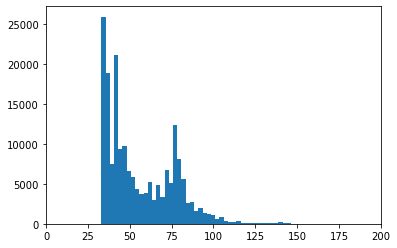

In [4]:

plt.hist(chla_df.Volts,bins=300)
plt.xlim(0,200)
plt.show()

(0.0, 3.0)

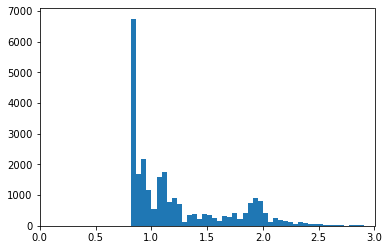

In [5]:
plt.hist(tsg_df.chla,bins=300)
plt.xlim(0,3)

In [6]:
len(tsg_df)

26518

<AxesSubplot:>

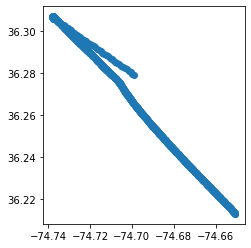

In [7]:
gdf = gpd.GeoDataFrame(
    tsg_df, geometry=gpd.points_from_xy(tsg_df.lon, tsg_df.lat))
gdf.loc['2022-03-10 13:00:00':'2022-03-10 15:45:00'].plot()

In [8]:
tsg_df.hvplot.points('lon', 'lat', geo=True, c='chla', alpha=1,tiles='EsriNatGeo')

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]   (chla)

#### pull in the SST data from GOES

In [9]:
goes_ds = xr.open_dataset('data/march_cruise/jplStarG16SSTv270_114c_3593_e68a.nc')

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'sea_surface_temperature' has multiple fill values {-327.67, -327.68}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


#### Pull in the TriOS radiometer data

In [87]:
trios_fns = [
    'data/ivan_cruise/trios/shearwater_trios_20210826.csv',
    'data/ivan_cruise/trios/shearwater_trios_20210827.csv',
    'data/ivan_cruise/trios/shearwater_trios_20210828.csv',
    'data/ivan_cruise/trios/shearwater_trios_20210829.csv',
            ]
trios_dfs = []
for fn in trios_fns:
    trios_dfs.append(pd.read_csv(fn))

trios_df = pd.DataFrame().append(trios_dfs)

Based on our notes I believe that the TriOS data was saved as local time so I convert it here to UTC. I have not included the offset compared to the inline but that is likely about 10 seconds or more.

In [88]:
trios_df['datetime'] = pd.to_datetime(trios_df['TimeStamp'])
trios_df['utc_dt'] =trios_df['datetime'] + timedelta(hours=4) # moving it to UTC
trios_df = trios_df.set_index('utc_dt')

<AxesSubplot:xlabel='utc_dt'>

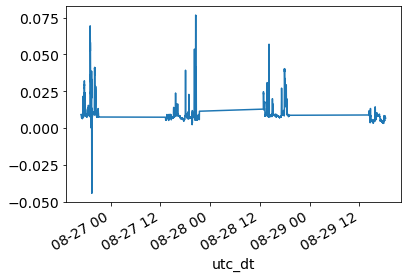

In [89]:
trios_df['400'].rolling(window=6*3).mean().plot()

In [90]:
# these are the coefficients based on the Hu et al 2012 paper

ci1 = -0.49
ci2 = 191.6590

# these are some coefficients that I calculated using the same exact method but trying to optimize for the Micasense bands

# ci1 = -0.38152295986028695
# ci2 = 271.37634868

# average of 443*.5 + 489*1.5
# ci1 = -0.30002281538304754
# ci2 = 310.5772338

# ci1 = -0.21380600002416383
# ci2 = 572.01573044



def oc_index(blue, green, red):
    blue, green, red = blue, green, red
    CI = green - ( blue + (555 - 477)/(667 - 477) * (red - blue) )
    ChlCI = 10**(ci1 + ci2*CI)
    return(ChlCI)

In [91]:
trios_df['chla_oci'] = oc_index(trios_df.iloc[:, 156:161].mean(axis=1).values, trios_df.iloc[:, 232:240].mean(axis=1).values, trios_df.iloc[:, 346:351].mean(axis=1).values)

Some of the values are way too high so cutting those off.

In [92]:
trios_df['chla_oci'][trios_df['chla_oci'] > 2 ] = np.nan

<ipython-input-92-edd115011d89>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trios_df['chla_oci'][trios_df['chla_oci'] > 2 ] = np.nan


(0.0, 0.4)

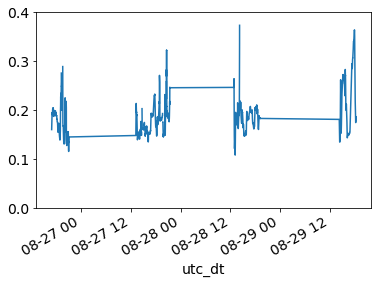

In [93]:
fig, ax = plt.subplots()
trios_df['chla_oci'].rolling(window=6*5).mean().plot(ax=ax)
ax.set_ylim(0,.4)

#### Filter all TriOS data for outliers and make dataset that is just the transects

In [12]:
i=6

In [11]:
start_times = ['2022-03-09 15:25', '2022-03-09 20:50','2022-03-10 12:59','2022-03-10 17:35','2022-03-11 14:02','2022-03-11 15:00','2022-03-11 16:05',]
end_times =   ['2022-03-09 18:30', '2022-03-09 22:59','2022-03-10 15:30','2022-03-10 20:30','2022-03-11 14:35','2022-03-11 15:30','2022-03-11 17:35',]

In [13]:
tsg_df.loc[start_times[i]:end_times[i]].hvplot.points('lon', 'lat', geo=True, c='chla', cmap='viridis', alpha=1,tiles='EsriNatGeo', width=700)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]   (chla)

This block is cutting off major outliers by doing a rolling median and eliminating anything that jumps substantually from that median assuming it is due to glint

In [95]:
trios_transects = []
timestamps = []

for i in range(13):
    if trios_df.loc[start_times[i]:end_times[i]].rolling(window=6*3).mean()['chla_oci'].empty:
        pass
    else:
        print(i)
        
        trios_df_transect = trios_df.loc[start_times[i]:end_times[i]]
        
        # Calculate rolling median and filter everything based on 440nm
        rolling_440 = trios_df_transect['440'].rolling(window=6*2).median()
        upper_threshold = 0.0005
        lower_threshold = -0.0005
        # filter based on threshold all in one line 
        df_filtered = trios_df_transect.drop(trios_df_transect[(trios_df_transect['440']-rolling_440>upper_threshold)|(trios_df_transect['440']- rolling_440<lower_threshold)].index) 

        trios_transects.append(df_filtered)
        timestamps.append(df_filtered['TimeStamp'])
        
trios_transects = pd.concat(trios_transects)

2
3
6
7
8
11
12


In [96]:
timestamps = [item for sublist in timestamps for item in sublist]

This block is subtracting the NIR from the whole spectrum AFTER doing the typical Mobley 1999 Lw = Lt - rho*Lsky

In [97]:
# subtract NIR from whole spectrum
corrected_specs = []
for i in range(len(trios_transects)):
    corrected_specs.append(trios_transects.iloc[i,1:-2] - trios_transects.iloc[i,450:480].mean())

corrected_specs = pd.DataFrame(corrected_specs, columns=df_filtered.columns[1:-2] )
corrected_specs['chla_oci'] = oc_index(corrected_specs.iloc[:, 156:161].mean(axis=1).values, corrected_specs.iloc[:, 232:240].mean(axis=1).values, corrected_specs.iloc[:, 346:351].mean(axis=1).values)
corrected_specs['TimeStamp'] = timestamps

lats = []
lons = []
sals = []
temps = []
for i in range(len(corrected_specs)):
    row = df.iloc[df.index.get_loc(pd.to_datetime(corrected_specs.iloc[i].TimeStamp) + timedelta(hours=4), method='nearest')]
    lats.append(row.lat)
    lons.append(row.lon)
    sals.append(row['TSG--sal'])
    temps.append(row['TSG--temp-SBE38'])
corrected_specs['lat'] = lats
corrected_specs['lon'] = lons
corrected_specs['sal'] = sals
corrected_specs['temp'] = temps

trios_gdf = gpd.GeoDataFrame(corrected_specs, geometry=gpd.points_from_xy(corrected_specs.lon, corrected_specs.lat))

In [98]:
corrected_specs.hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.05,tiles='EsriNatGeo')

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]

### Pull in HPLC timings

In [99]:
# hplc_df = pd.read_csv('data/ivan_cruise/hplc_timing.csv') # this is just timings
hplc_df = pd.read_csv('data/ivan_cruise/hplc_data_Windle_aug_2021.csv')

In [100]:
hplc_df.head()

Horn Point Lab sample code  sample #  Date  Time (LST)  \
0                       AW 1        11  27-8        1207   
1                       AW 2        12  27-8        1300   
2                       AW 3        13  27-8        1333   
3                       AW 4        17  28-8        1116   
4                       AW 5        18  28-8        1217   

                                 Cruise Notes  Vf (ml)  \
0      beginning of transect on offshore side      500   
1                                    at front      500   
2                    last profile of transect      500   
3  beginning tow-yo survey from offshore side      500   
4                          crossing the front      500   

  date extracted at Horn Point (month/day/year)  Vx (ml)  [TChl a]  [TChl b]  \
0                                       2/23/22    2.841     0.407     0.001   
1                                       2/23/22    2.787     0.165     0.012   
2                                       2/23/22    2.795     0.228     0.007   
3                                       2/23/22    2.760     0.128     0.013   
4                                       2/23/22    2.785     0.171     0.007   

   ...  [TAcc]  [TPig]   [DP]  [TAcc]/[Tchla]  [PSC]/[TCaro]  [PPC]/[TCaro]  \
0  ...   0.145   0.552  0.100            0.36           0.10           0.90   
1  ...   0.157   0.322  0.127            0.95           0.11           0.89   
2  ...   0.181   0.409  0.148            0.79           0.10           0.90   
3  ...   0.129   0.257  0.106            1.01           0.11           0.89   
4  ...   0.158   0.329  0.127            0.92           0.13           0.87   

   [TChl]/[TCaro]  [PPC]/[Tpig]  [PSP]/[TPig]  [TChl a]/[TPig]  
0            3.09          0.22          0.78             0.74  
1            1.40          0.37          0.63             0.51  
2            1.46          0.36          0.64             0.56  
3            1.36          0.38          0.62             0.50  
4            1.33          0.37          0.63             0.52  

[5 rows x 50 columns]

In [101]:
hplc_df['datetime'] = pd.to_datetime([datetime.strptime(x, '%Y %d-%m %H%M') for x in '2021 ' + hplc_df.Date + ' ' + hplc_df['Time (LST)'].astype(str)])
hplc_df['datetime']   = hplc_df['datetime'] + timedelta(hours=4) # moving it to UTC
hplc_df['utc_dt']   = hplc_df['datetime']
hplc_df = hplc_df.set_index('utc_dt')

In [424]:
goes_ds.sea_surface_temperature[:,50:200, 300:450]

<xarray.DataArray 'sea_surface_temperature' (time: 239, latitude: 150, longitude: 150)>
[5377500 values with dtype=float32]
Coordinates:
  * time       (time) object 2022-03-04 13:00:00 ... 2022-03-14 13:00:00
  * latitude   (latitude) float32 37.01 36.99 36.97 36.95 ... 34.07 34.05 34.03
  * longitude  (longitude) float32 -76.99 -76.97 -76.95 ... -74.05 -74.03 -74.01
Attributes:
    colorBarMaximum:  32.0
    colorBarMinimum:  0.0
    comment:          SST obtained by regression with buoy measurements, sens...
    grid_mapping:     crs
    ioos_category:    Temperature
    long_name:        Sea Surface Sub-Skin Temperature
    source:           NOAA
    standard_name:    sea_surface_subskin_temperature
    units:            degree_C
    valid_max:        327.67
    valid_min:        -327.67

In [444]:
goes_ds.sea_surface_temperature[:,100:130, 400:430].hvplot.quadmesh(
    'longitude', 'latitude', projection=crs.PlateCarree(), project=True,
    cmap='inferno', dynamic=True, 
    frame_height=200, clim=(13, 26), rasterize=True) * tsg_df.loc[start_times[i]:end_times[i]].hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.01)

:DynamicMap   [time]
   :Overlay
      .Image.I  :Image   [longitude,latitude]   (sea_surface_temperature)
      .Points.I :Points   [lon,lat]

### Grab profile data

In [110]:
import scipy.io
names=['c1t1', 'c1t2', 'c1t3', 'c1t4', 'c1t5', 'c1t6', 'c1t7', 'c1t8']
li = []
for i, fn in enumerate(glob.glob("data/VMP/Cruise1/*.mat")):
    mat = scipy.io.loadmat(fn)
    for item in list(mat.keys()):
        if item not in ['__header__', '__version__', '__globals__']:
            df = pd.DataFrame(data=mat[item], columns=['time', 'depth (dBars)', 'temp (C)','salinity (PSU)', 'potential density (kg/m^3 -1000)', 
                                                    'chla (ppb)', 'turbidity (FTU)', 'turb kinetic energy 1 (W/kg)', 'turb kinetic energy 2 (W/kg)'])
            df['transect'] = names[i]
            df['profile_num'] = item.split('profile')[-1]
            li.append(df)

profiles = pd.concat(li, axis=0, ignore_index=True)
profiles['dt'] = pd.to_datetime('2021-1-1') + pd.to_timedelta(profiles.time, unit='D') - pd.Timedelta(days=1)
profiles = profiles.set_index('dt')
profiles = profiles.sort_index(ascending=True)
profiles['datetime'] = pd.to_datetime('2021-1-1') + pd.to_timedelta(profiles.time, unit='D') - pd.Timedelta(days=1)
profiles['profile_num'] = profiles.profile_num.astype(int)

In [111]:
import numpy as np
# from scipy.interpolate import interp2d
import scipy


data_variables = ['temp (C)', 'salinity (PSU)',
       'potential density (kg/m^3 -1000)', 'chla (ppb)', 'turbidity (FTU)',
       'turb kinetic energy 1 (W/kg)', 'turb kinetic energy 2 (W/kg)']

def interpolate_profiles(df, transect, data_variables, plot=False):
    df_subset = df[df.transect == transect]
    interpolated_grids = []
    datetime_list = []
    for i in np.unique(df_subset.profile_num.values):
        datetime_list.append(df_subset[df_subset.profile_num == i].head(1).datetime.values)
    datetime_list = np.array(datetime_list)
    datetime_strings = np.datetime_as_string(datetime_list.flatten(), unit='m')
    
    # Original data (e.g. measurements)
    for data_var in data_variables:
        x_interp = np.arange(1,len(datetime_list), 1)
        y_interp = np.arange(-1,-115, -1)

        xx, yy = np.meshgrid(x_interp, y_interp)
        Z_table = df_subset[data_var].values

        Z = scipy.interpolate.griddata(np.array(list(zip(df_subset.profile_num.values , df_subset['depth (dBars)'].values ))), Z_table, (xx, yy), method='linear')

        datetime_list = []
        for i in np.unique(df_subset.profile_num.values):
            datetime_list.append(df_subset[df_subset.profile_num == i].head(1).datetime.values)
        datetime_list = np.array(datetime_list)
        datetime_strings = np.datetime_as_string(datetime_list.flatten(), unit='m')
        
        interpolated_grids.append(Z)

        if plot:
            cmap='RdYlBu_r'
            norm=None
            fig, ax = plt.subplots(figsize=(9,7))
            if data_var == 'temp (C)':
                cmap='inferno'
                vmin=15
                vmax=28.5
            elif data_var == 'salinity (PSU)':
                vmin=34.5
                vmax=36.5
            elif data_var == 'potential density (kg/m^3 -1000)':
                vmin=22
                vmax=26.3
            elif data_var == 'chla (ppb)':
                vmin=-0.3
                vmax=0.5
                cmap='viridis'
            elif data_var == 'turbidity (FTU)':
                vmin=1
                vmax=1.12
            elif data_var == 'turb kinetic energy 1 (W/kg)':
                vmin=1e-10
                vmax=1e-6
                norm=colors.LogNorm()
            elif data_var == 'turb kinetic energy 2 (W/kg)':
                vmin=1e-10
                vmax=1e-6
                norm=colors.LogNorm()
            
                
            sc = ax.scatter(df_subset['datetime'], df_subset['depth (dBars)'],c=df_subset[data_var],cmap=cmap, s=20, alpha=1, vmin=vmin,vmax=vmax, norm=norm)
            ax.set_ylim(-100,0)
#             ax.set_xlim(df_subset['datetime'].max()+timedelta(hours=.1),df_subset['datetime'].min()-timedelta(hours=.1))
            cb = fig.colorbar(sc)
            cb.set_label(data_var)
            ax.set_ylabel('Depth (m')
            ax.set_xlabel('Time (UTC)')
        #     ax[1].xaxis.set_major_locator(plt.MaxNLocator(7))
            fig.autofmt_xdate(rotation=45)
#             ax.xaxis.set_major_locator(plt.MaxNLocator(15))

            fig.savefig('figs/aug_'+transect+'_profile_'+data_var[:20]+'.png')
            plt.show()
    return(datetime_list, interpolated_grids)

In [214]:
def plot_profiles(df, start_time, end_time, data_variables, plot=False):
    df_subset = df.loc[start_time:end_time]
#     print(df_subset.head())
    interpolated_grids = []
    datetime_list = []
    for i in np.unique(df_subset.profile_num.values):
        datetime_list.append(df_subset[df_subset.profile_num == i].head(1).datetime.values)
    datetime_list = np.array(datetime_list)
    datetime_strings = np.datetime_as_string(datetime_list.flatten(), unit='m')
    
    # Original data (e.g. measurements)
    for data_var in data_variables:
        x_interp = np.arange(1,len(datetime_list), 1)
        y_interp = np.arange(-1,-115, -1)

        xx, yy = np.meshgrid(x_interp, y_interp)
        Z_table = df_subset[data_var].values

        Z = scipy.interpolate.griddata(np.array(list(zip(df_subset.profile_num.values , df_subset['depth (dBars)'].values ))), Z_table, (xx, yy), method='linear')

        datetime_list = []
        for i in np.unique(df_subset.profile_num.values):
            datetime_list.append(df_subset[df_subset.profile_num == i].head(1).datetime.values)
        datetime_list = np.array(datetime_list)
        datetime_strings = np.datetime_as_string(datetime_list.flatten(), unit='m')
        
        interpolated_grids.append(Z)

        if plot:
            cmap='RdYlBu_r'
            norm=None
            fig, ax = plt.subplots(figsize=(17.2,7))
            if data_var == 'temp (C)':
                cmap='inferno'
                vmin=15
                vmax=29
            elif data_var == 'salinity (PSU)':
                vmin=35
                vmax=36.2
            elif data_var == 'potential density (kg/m^3 -1000)':
                vmin=22
                vmax=26.3
            elif data_var == 'chla (ppb)':
                vmin=-0.3
                vmax=0.5
                cmap='viridis'
            elif data_var == 'turbidity (FTU)':
                vmin=1
                vmax=1.12
            elif data_var == 'turb kinetic energy 1 (W/kg)':
                vmin=1e-10
                vmax=1e-6
                norm=colors.LogNorm()
            elif data_var == 'turb kinetic energy 2 (W/kg)':
                vmin=1e-10
                vmax=1e-6
                norm=colors.LogNorm()
            
                
            sc = ax.scatter(df_subset['datetime'], df_subset['depth (dBars)'],c=df_subset[data_var],cmap=cmap, s=20, alpha=1, vmin=vmin,vmax=vmax, norm=norm)
            ax.set_ylim(-100,0)
#             ax.set_xlim(df_subset['datetime'].max()+timedelta(hours=.1),df_subset['datetime'].min()-timedelta(hours=.1))
            cb = fig.colorbar(sc)
            cb.set_label(data_var)
            ax.set_ylabel('Depth (m')
            ax.set_xlabel('Time (UTC)')
            ax.set_xlim(pd.to_datetime(start_time), pd.to_datetime(end_time))
        #     ax[1].xaxis.set_major_locator(plt.MaxNLocator(7))
            fig.autofmt_xdate(rotation=45)
#             ax.xaxis.set_major_locator(plt.MaxNLocator(15))

#             fig.savefig('figs/aug_'+transect+'_profile_'+data_var[:20]+'.png')
            plt.show()

In [215]:
# I've re-ordered these to be in ascending time
profile_transect_names=[ 'c1t4','c1t8', 'c1t3','c1t5', 'c1t6', 'c1t7', 'c1t2','c1t1']

In [15]:
start_times[1]

'2022-03-09 20:50'

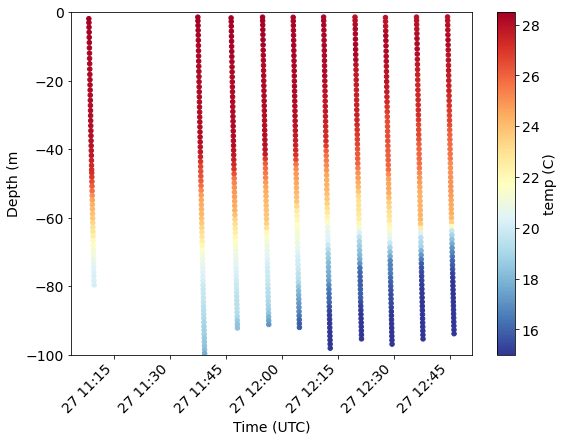

In [217]:
dates, interpolated_grids = interpolate_profiles(profiles, profile_transect_names[2], [data_variables[0]], plot=True)

### Add in density

In [89]:
tsg_df['Sal_smooth'] = tsg_df.Sal.rolling(window=7).median()
tsg_df['Temp_smooth'] = tsg_df.Temp.rolling(window=7).median()

In [90]:
import gsw
tsg_df['sigma'] = gsw.density.sigma0(tsg_df.Sal_smooth, tsg_df.Temp_smooth).rolling(window=5).mean()
tsg_df['sigma_grad'] = np.gradient(tsg_df['sigma'])

## Visualizing transects with good sample data

In [60]:
samples_df = pd.read_csv('data/feb_cruise/GSF_Sampling_Table_tidy.csv')
samples_df['datetime'] = [datetime.strptime(x[:-1], '%d-%b-%y %H:%M:%S') for x in samples_df.Date+' '+samples_df['Ship Time']]
samples_df['utc_dt'] = samples_df['datetime']
samples_df  = samples_df.set_index('utc_dt')

In [61]:
lats = []
lons = []
chlas = []
sals = []
temps = []

for i in range(len(samples_df)):
    row = tsg_df.iloc[tsg_df.index.get_loc(samples_df.iloc[i].datetime, method='nearest')]
    lats.append(row.lat)
    lons.append(row.lon)
    chlas.append(row.chla)
    sals.append(row.Sal)
    temps.append(row.Temp)
    
samples_df['lat'] = lats
samples_df['lon'] = lons
samples_df['chla'] = chlas
samples_df['sal'] = sals
samples_df['temp'] = temps

In [93]:
samples_df.to_csv('GSF_Sampling_Table_tidy_combined_march.csv')

In [63]:
samples_df.head()

Cruise  Transect  Stations       Date Ship Time  FCM  \
utc_dt                                                                     
2022-01-31 16:58:04    Feb         2         1  31-Jan-22  16:58:42    1   
2022-01-31 17:42:02    Feb         2         2  31-Jan-22  17:42:24    1   
2022-01-31 18:04:01    Feb         2         3  31-Jan-22  18:04:15    1   
2022-01-31 18:35:02    Feb         2         4  31-Jan-22  18:35:25    1   
2022-02-02 15:05:00    Feb         4         1   2-Feb-22  15:05:01    1   

                     Nutrients  Viromics  Microscopy   16S/18S  \
utc_dt                                                           
2022-01-31 16:58:04          1         1            1        0   
2022-01-31 17:42:02          1         1            1        0   
2022-01-31 18:04:01          1         0            1        0   
2022-01-31 18:35:02          1         1            1        0   
2022-02-02 15:05:00          1         0            0        0   

                           Category            datetime        lat        lon  \
utc_dt                                                                          
2022-01-31 16:58:04     Gulf Stream 2022-01-31 16:58:04  34.544948 -76.605212   
2022-01-31 17:42:02     Gulf Stream 2022-01-31 17:42:02  34.544948 -76.605212   
2022-01-31 18:04:01  Front/Filament 2022-01-31 18:04:01  34.544948 -76.605212   
2022-01-31 18:35:02  Front/Filament 2022-01-31 18:35:02  34.544948 -76.605212   
2022-02-02 15:05:00     Gulf Stream 2022-02-02 15:05:00  34.544948 -76.605212   

                     chla      sal     temp                    geometry  
utc_dt                                                                   
2022-01-31 16:58:04  1.07  36.1202  16.2645  POINT (-76.60521 34.54495)  
2022-01-31 17:42:02  1.07  36.1202  16.2645  POINT (-76.60521 34.54495)  
2022-01-31 18:04:01  1.07  36.1202  16.2645  POINT (-76.60521 34.54495)  
2022-01-31 18:35:02  1.07  36.1202  16.2645  POINT (-76.60521 34.54495)  
2022-02-02 15:05:00  1.07  36.1202  16.2645  POINT (-76.60521 34.54495)

<AxesSubplot:>

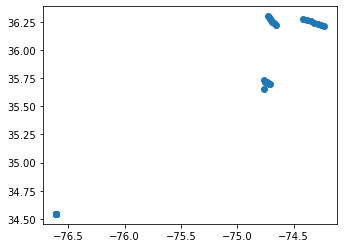

In [62]:
samples_gdf = gpd.GeoDataFrame(
    samples_df, geometry=gpd.points_from_xy(samples_df.lon, samples_df.lat))
samples_gdf.plot()

In [47]:
i=2
tsg_df.loc[start_times[i]:end_times[i]].hvplot.points('lon', 'lat', geo=True, c='chla', cmap='viridis', alpha=1,tiles='EsriNatGeo', width=700)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]   (chla)

In [12]:
start_times = ['2022-03-10 12:59','2022-03-10 17:35','2022-03-11 15:00','2022-03-11 16:05',]
end_times =   ['2022-03-10 15:30','2022-03-10 20:30','2022-03-11 15:46','2022-03-11 17:35',]

In [13]:
plt.rcParams.update({'font.size': 14})

In [14]:
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%b %d %y - %H:%M')

<ipython-input-92-c1cf0ba77803>:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  temp_ax.set_xticklabels(temp_ax.get_xticklabels(), rotation=15, ha='right')
<ipython-input-92-c1cf0ba77803>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  density_ax.set_xticklabels(temp_ax.get_xticklabels(), rotation=15, ha='right')
<ipython-input-92-c1cf0ba77803>:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  chla_ax.set_xticklabels(temp_ax.get_xticklabels(), rotation=15, ha='right')


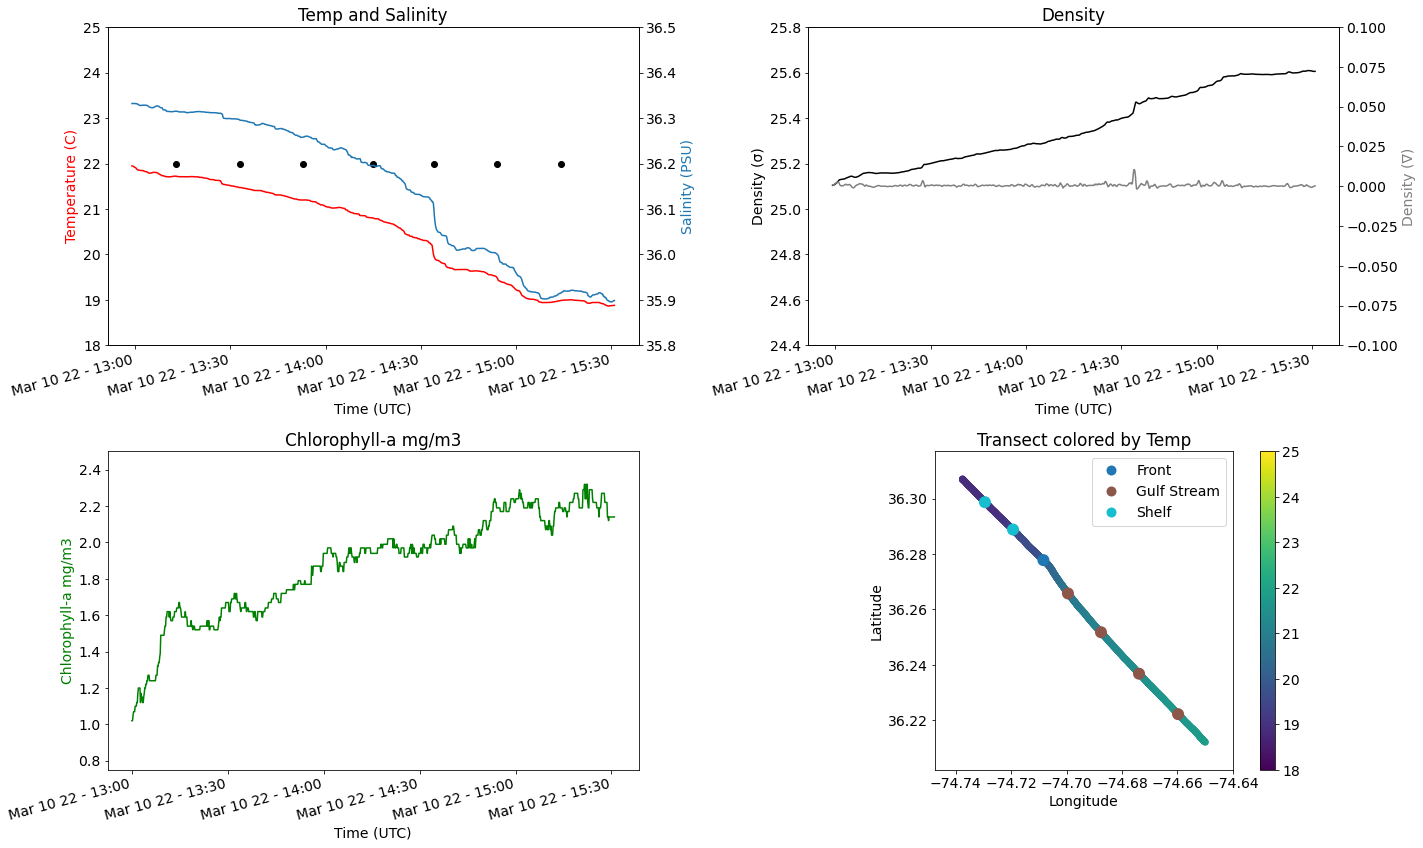

----------------------------------------------------------------------------------------------------------


<ipython-input-92-c1cf0ba77803>:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  temp_ax.set_xticklabels(temp_ax.get_xticklabels(), rotation=15, ha='right')
<ipython-input-92-c1cf0ba77803>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  density_ax.set_xticklabels(temp_ax.get_xticklabels(), rotation=15, ha='right')
<ipython-input-92-c1cf0ba77803>:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  chla_ax.set_xticklabels(temp_ax.get_xticklabels(), rotation=15, ha='right')


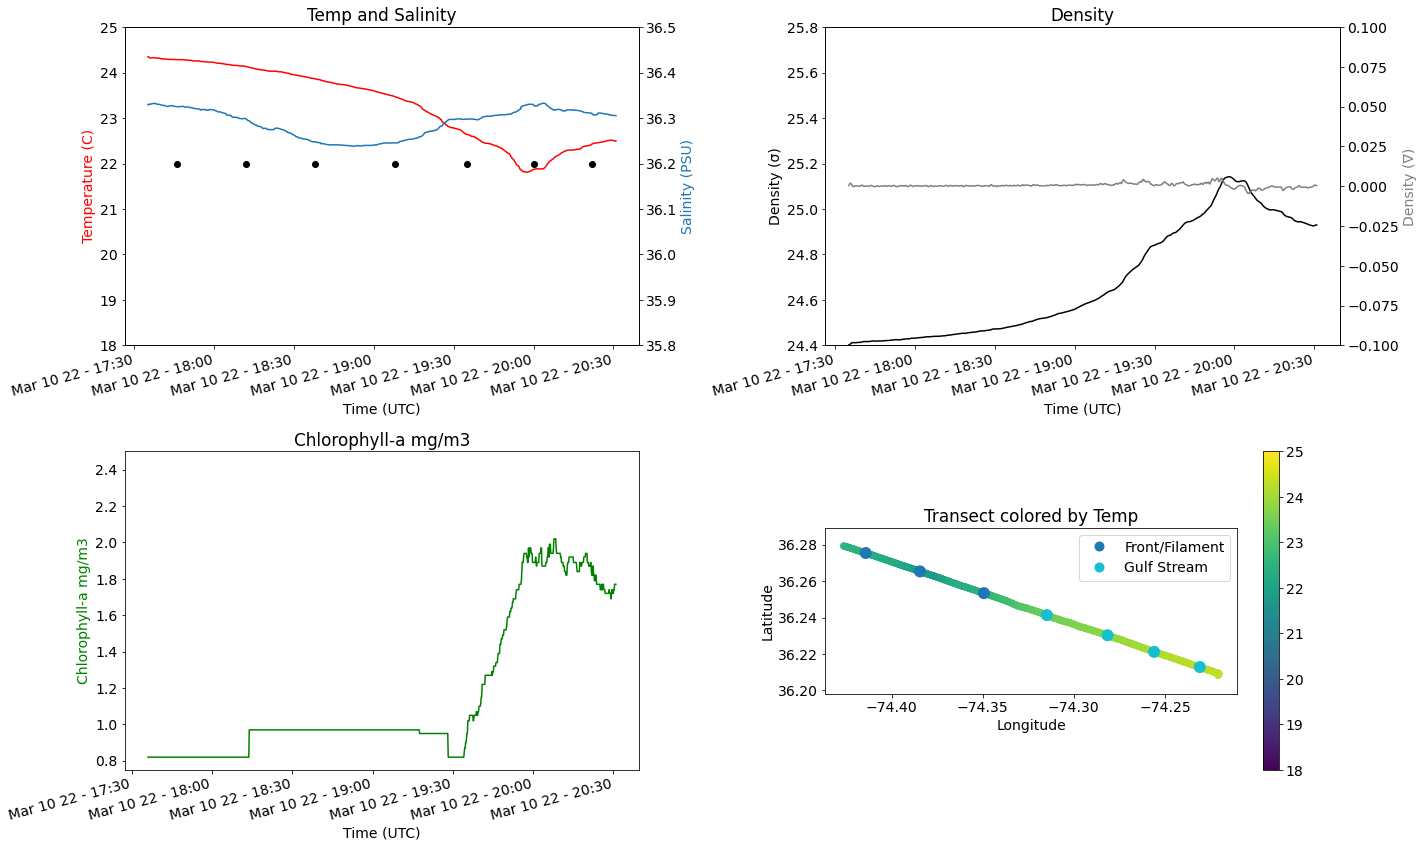

----------------------------------------------------------------------------------------------------------


<ipython-input-92-c1cf0ba77803>:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  temp_ax.set_xticklabels(temp_ax.get_xticklabels(), rotation=15, ha='right')
<ipython-input-92-c1cf0ba77803>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  density_ax.set_xticklabels(temp_ax.get_xticklabels(), rotation=15, ha='right')
<ipython-input-92-c1cf0ba77803>:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  chla_ax.set_xticklabels(temp_ax.get_xticklabels(), rotation=15, ha='right')


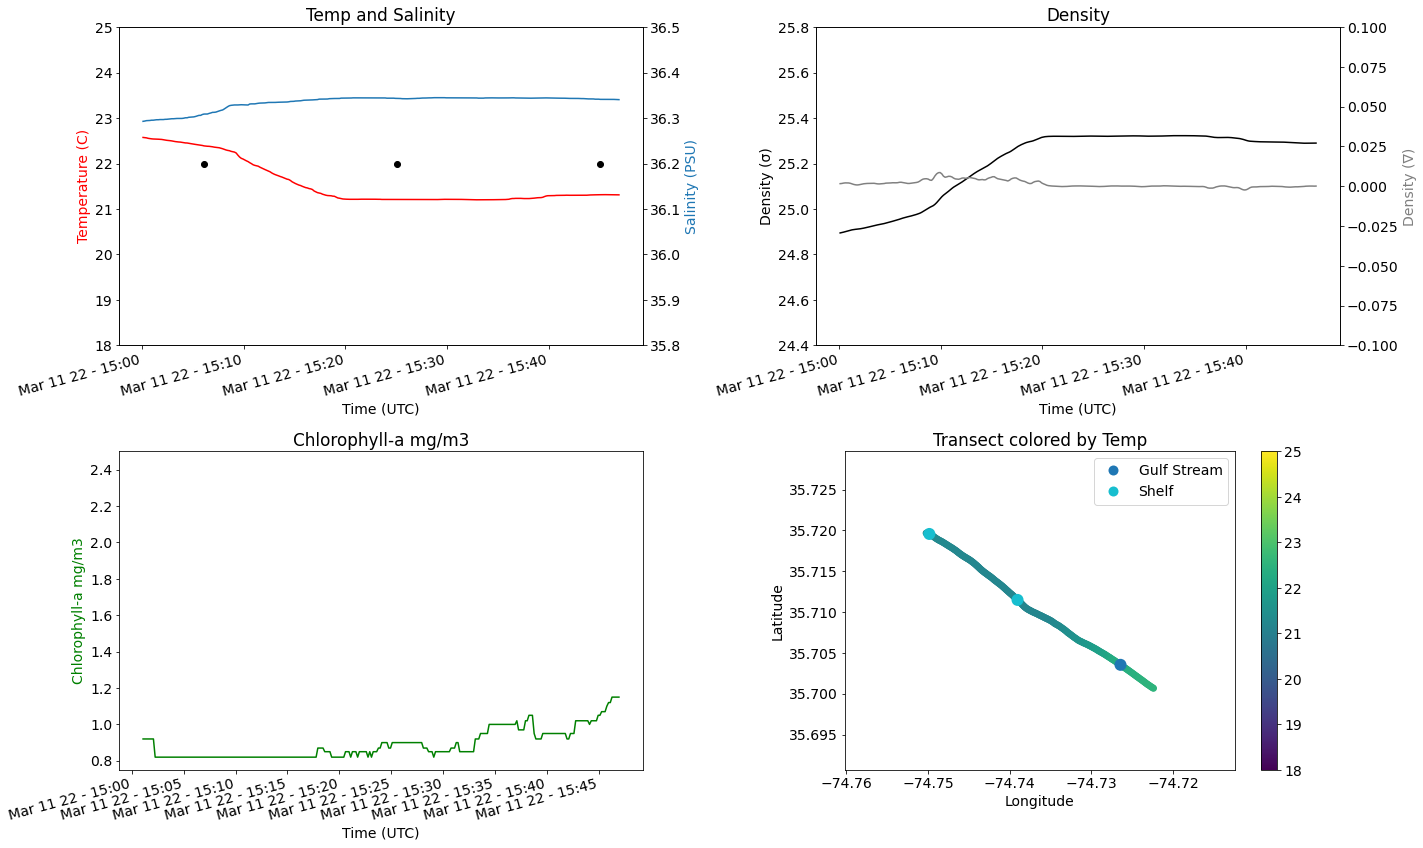

----------------------------------------------------------------------------------------------------------


<ipython-input-92-c1cf0ba77803>:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  temp_ax.set_xticklabels(temp_ax.get_xticklabels(), rotation=15, ha='right')
<ipython-input-92-c1cf0ba77803>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  density_ax.set_xticklabels(temp_ax.get_xticklabels(), rotation=15, ha='right')
<ipython-input-92-c1cf0ba77803>:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  chla_ax.set_xticklabels(temp_ax.get_xticklabels(), rotation=15, ha='right')


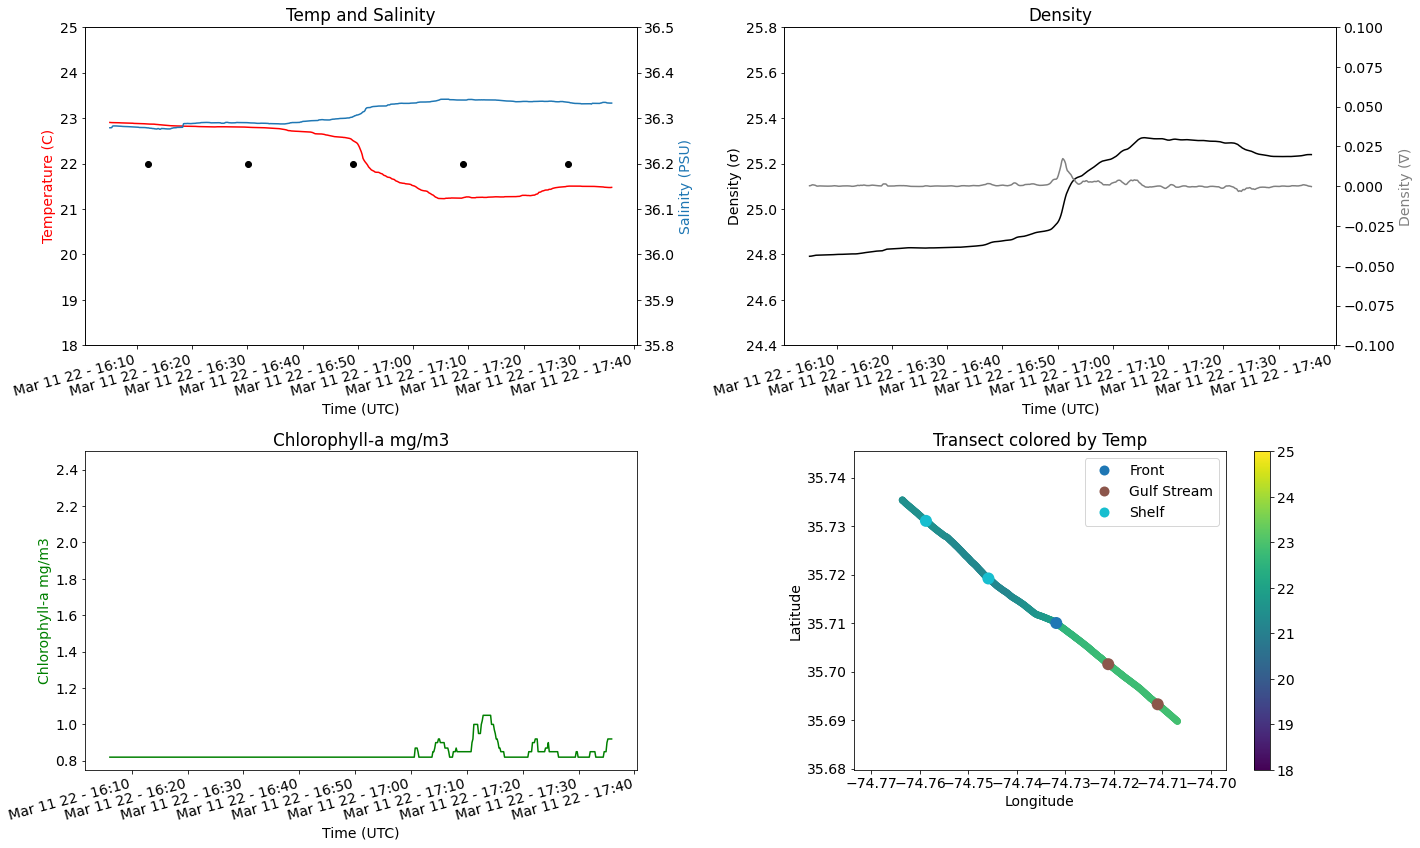

----------------------------------------------------------------------------------------------------------


In [92]:
titles=['March 2022 T1','March 2022 T2', 'March 2022 T3','March 2022 T4']
for i in range(4):
# for i in [0,1,4,5,8]:
    # time series plot
    fig = plt.figure(figsize=(20,12))

    gs = fig.add_gridspec(2,2)

    temp_ax = fig.add_subplot(gs[0, 0]) # S/T
    density_ax = fig.add_subplot(gs[0, 1]) # density
    chla_ax = fig.add_subplot(gs[1, 0])
    map_ax = fig.add_subplot(gs[1, 1])

    sal_ax = temp_ax.twinx()
    density_grad_ax = density_ax.twinx()


    temp_ax.set_ylim(18, 25)
    sal_ax.set_ylim(35.8, 36.5)
    chla_ax.set_ylim(.75, 2.5)
    density_ax.set_ylim(24.4, 25.8)
    density_grad_ax.set_ylim(-.1, .1)

#   ax.set_xlabel("Time (UTC)")
    temp_ax.set_title("Temp and Salinity")
    temp_ax.set_ylabel("Temperature (C)")
    sal_ax.set_ylabel("Salinity (PSU)")

    chla_ax.set_title("Chlorophyll-a mg/m3")
    chla_ax.set_ylabel("Chlorophyll-a mg/m3")

    density_ax.set_title('Density')
    density_ax.set_ylabel('Density (σ)')
    density_grad_ax.set_ylabel('Density (∇)')
    
    temp_ax.set_xlabel("Time (UTC)")
    density_ax.set_xlabel("Time (UTC)")
    chla_ax.set_xlabel("Time (UTC)")
    
    map_ax.set_title('Transect colored by Temp')
    map_ax.set_ylabel('Latitude')
    map_ax.set_xlabel('Longitude')
    map_ax.ticklabel_format(useOffset=False)
    
    sample_len = len(samples_df.loc[start_times[i]:end_times[i]].index)
    temp_ax.scatter(samples_df.loc[start_times[i]:end_times[i]].index, [22]*sample_len, color='black', label='Sample')

    p1, = temp_ax.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['Temp_smooth'], color='red', label='Temp')
    p2, = sal_ax.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['Sal_smooth'], label='Salinity')

    p3, = density_ax.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['sigma'], label='Density (sigma)',  color='black')
    p4, = density_grad_ax.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['sigma_grad'], label='Density (sigma)',  color='grey')

    p5, = chla_ax.plot(tsg_df[tsg_df['chla'].notnull()].loc[start_times[i]:end_times[i]].index, 
                     tsg_df[tsg_df['chla'].notnull()].loc[start_times[i]:end_times[i]]['chla'].rolling(window=7).median(), label='Chla mg/m3', color='green')
    
    gdf_subset = gdf.loc[start_times[i]:end_times[i]]
    gdf_subset.plot(column='Temp',ax=map_ax, legend=True, vmin=18, vmax=25)

    samples_gdf_subset = samples_gdf.loc[start_times[i]:end_times[i]]
    samples_gdf_subset.plot('Category',ax=map_ax,lw=2, legend=True, facecolor='none', s=100)
    
    map_ax.set_ylim(gdf_subset.lat.min()-0.01, gdf_subset.lat.max()+0.01)
    map_ax.set_xlim(gdf_subset.lon.min()-0.01, gdf_subset.lon.max()+0.01)
    
    temp_ax.set_xticklabels(temp_ax.get_xticklabels(), rotation=15, ha='right')
    density_ax.set_xticklabels(temp_ax.get_xticklabels(), rotation=15, ha='right')
    chla_ax.set_xticklabels(temp_ax.get_xticklabels(), rotation=15, ha='right')

    temp_ax.xaxis.set_major_formatter(myFmt)
    density_ax.xaxis.set_major_formatter(myFmt)
    chla_ax.xaxis.set_major_formatter(myFmt)

    temp_ax.yaxis.label.set_color(p1.get_color())
    sal_ax.yaxis.label.set_color(p2.get_color())
    density_ax.yaxis.label.set_color(p3.get_color())
    density_grad_ax.yaxis.label.set_color(p4.get_color())
    chla_ax.yaxis.label.set_color(p5.get_color())

    # Adjust spacings w.r.t. figsize
    fig.tight_layout()
    fig.savefig('figs/march_transects'+titles[i] +'.png',dpi=600)
#     plt.close()
    plt.show()
    print('----------------------------------------------------------------------------------------------------------')

#         fig, ax = plt.subplots(figsize=(10,8))
#         sc = ax.scatter(df.loc[start_times[i]:end_times[i]]['TSG--sal'],  df.loc[start_times[i]:end_times[i]]['TSG--temp-SBE38'], alpha=0.8,c=df.loc[start_times[i]:end_times[i]]['lon'], cmap='cividis', label='chla')
#         ax.set_xlim(33,37)
#         ax.set_ylim(25,31)

#         ax.set_xlabel("Salinity")
#         ax.set_ylabel("Temperature")
#         ax.axvline(35.7)
#         ax.axvline(34.5)

#         fig.savefig('figs/march_transects'+titles[i] +'.png')
#         fig.colorbar(sc)

## Visualizing the subset of transects

In [218]:
plt.rcParams.update({'font.size': 14})

In [16]:
df = tsg_df

In [364]:
len(start_times)

7

In [373]:
tsg_df.chla.min()

0.82

In [17]:
tsg_df_subset.Sal.max()

NameError: name 'tsg_df_subset' is not defined

In [449]:
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%m/%d/%Y - %H:%M')

In [38]:
goes_ds_mean = goes_ds.sel(time=slice('2022-03-08 12:59', '2022-03-13 12:59')).mean(dim='time')

0


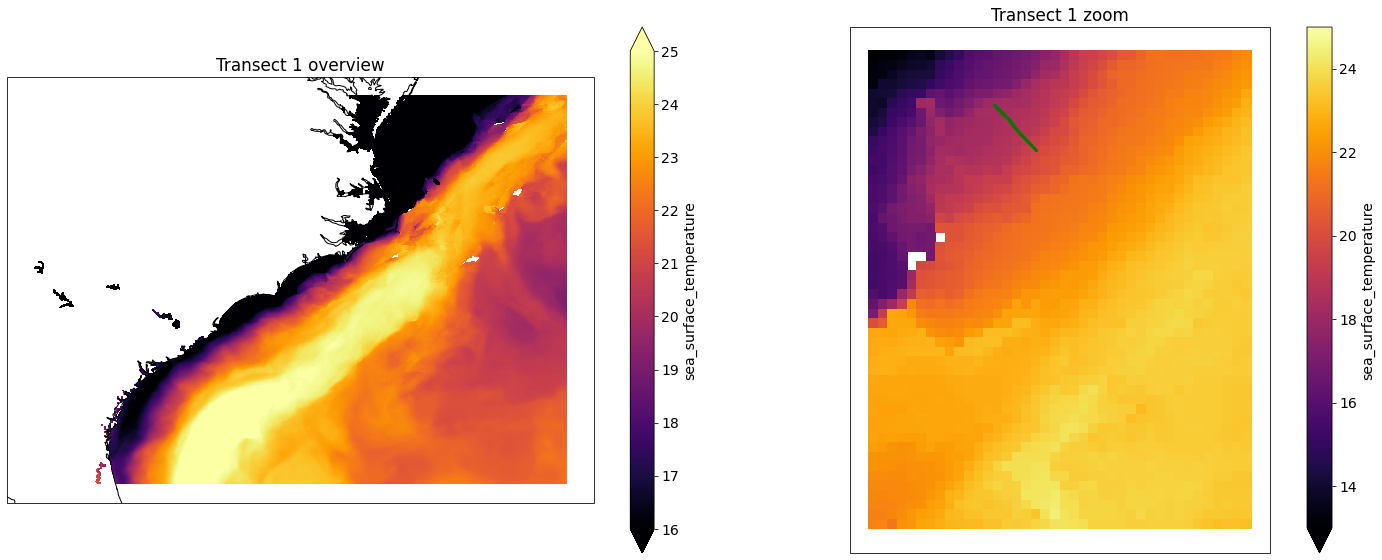

1


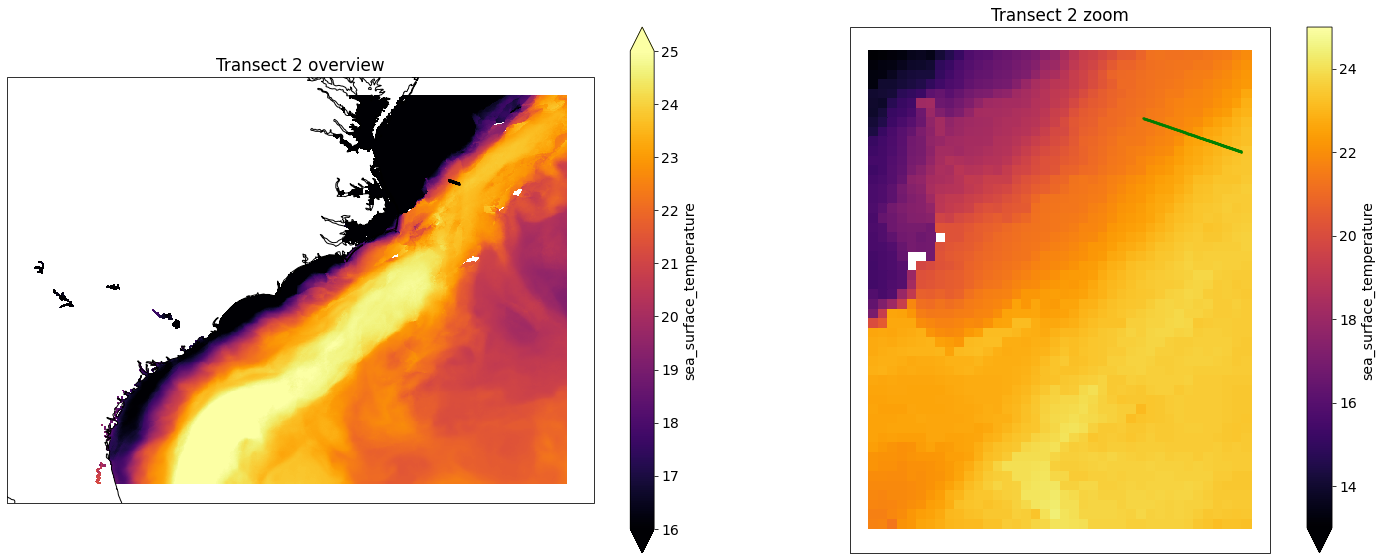

2


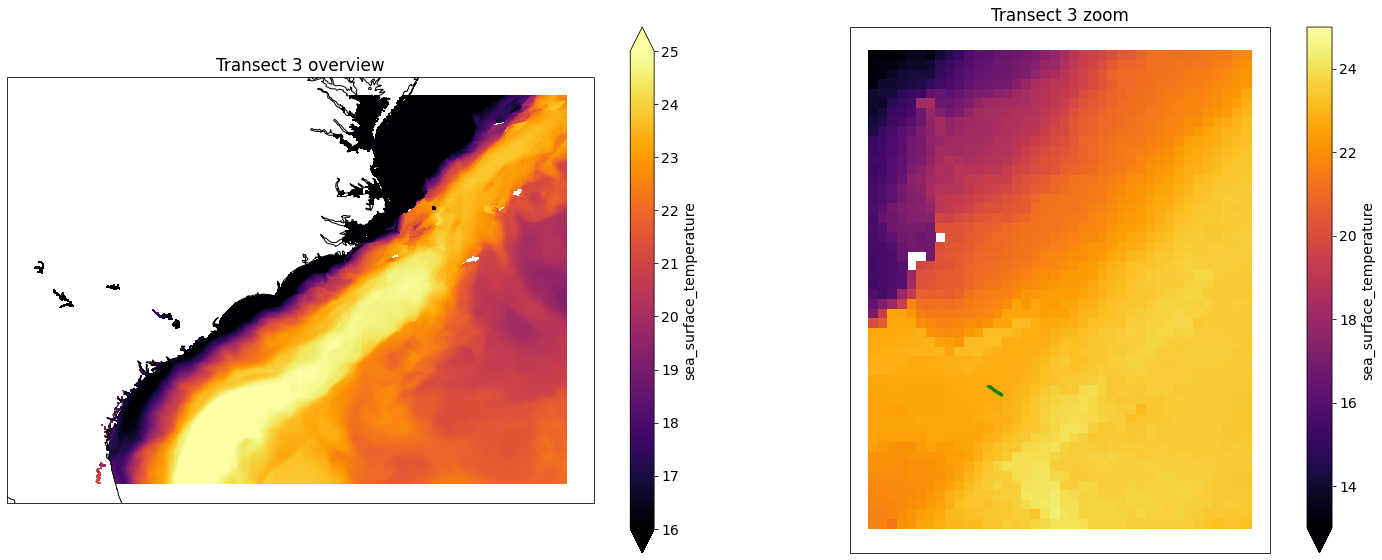

3


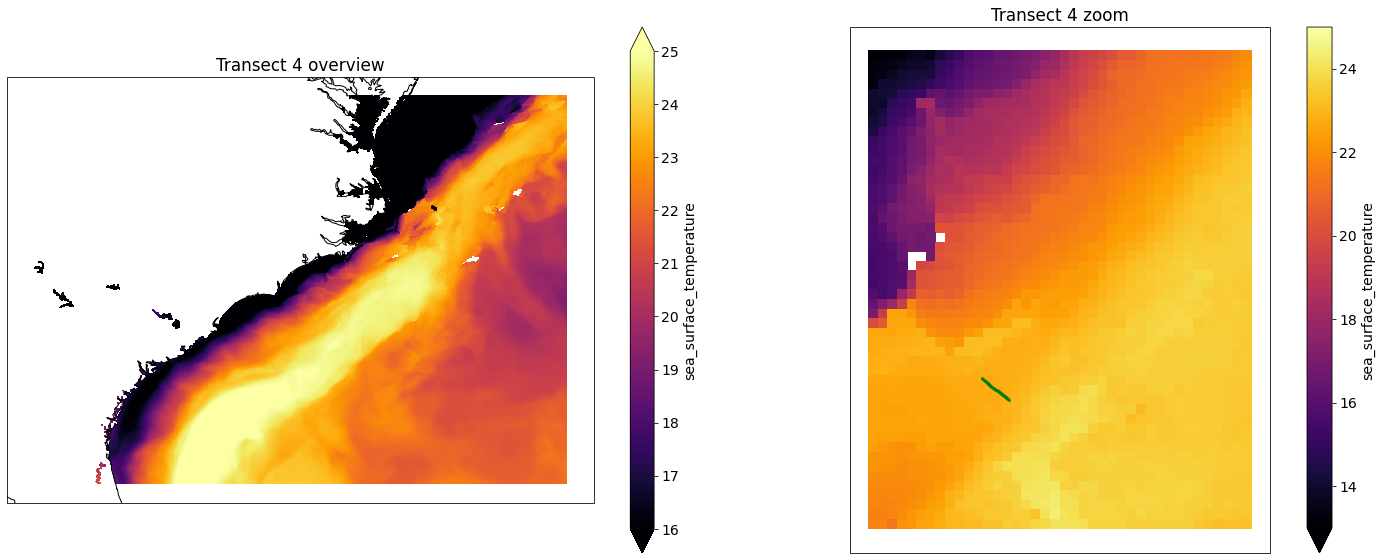

In [30]:
hours = [12,12,12,12,12,12,12,12,12,12,12,12,12]

titles = ['Transect 1', 'Transect 2', 'Transect 3', 'Transect 4', 
        'Transect 5', 'Transect 6', 'Transect 7', 'Transect 8',
        'Transect 9', 'Transect 10', 'Transect 11', 'Transect 12', 'Transect 13']

for i in range(4):
#     if trios_df.loc[start_times[i]:end_times[i]]['chla_oci'].empty:
#         pass
# #     elif hplc_df.loc[start_times[i]:end_times[i]]['datetime'].empty:
# #         pass
#     else:
        print(i)
        """

        # time series plot
        fig, ax = plt.subplots(figsize=(18,7))
        
        ax.set_xlim(pd.to_datetime(start_times[i]), pd.to_datetime(end_times[i]))

        ax1 = ax.twinx()
        ax2 = ax.twinx()
#         ax3 = ax.twinx()
#         ax4 = ax.twinx()
#         ax5 = ax.twinx()

        ax.set_ylim(18.3, 25)
        ax1.set_ylim(35.8, 36.5)
        ax2.set_ylim(0, 1.8)
#         ax3.set_ylim(.0, .50)
#         ax4.set_ylim(.07, .50)
#         ax5.set_ylim(.07, .50)

        ax.set_xlabel("Time (UTC)")
        ax.set_ylabel("Temperature (C)")
        ax1.set_ylabel("Salinity (PSU)")
        ax2.set_ylabel("Chla (mg/m3)")
#         ax2.set_ylabel("CDOM (volts)")
#         ax3.set_ylabel("Chla (mg/m3)")
#         ax4.set_ylabel("HPLC chl a (mg/m3)")
#         ax5.set_ylabel("HPLC Zea (mg/m3)")
        
        color1 = plt.cm.viridis(0)
        color2 = plt.cm.viridis(0.5)
        color3 = plt.cm.viridis(.9)

        p1, = ax.plot(df.loc[start_times[i]:end_times[i]].index, df.loc[start_times[i]:end_times[i]]['Temp'], color='red', label='Temp')
        p2, = ax1.plot(df.loc[start_times[i]:end_times[i]].index, df.loc[start_times[i]:end_times[i]]['Sal'].rolling(window=10).median(), label='Salinity')
        p3, = ax2.plot(df.loc[start_times[i]:end_times[i]].index, df.loc[start_times[i]:end_times[i]]['chla']-.72, color='green', label='Chla')
        
        
#         if cdom_df.loc[start_times[i]:end_times[i]].rolling(window=6*10).mean()['cdom_volts'].empty:
#             cdom_data_x = None
#             cdom_data_y = None
#         else:
#             cdom_data_x = cdom_df.loc[start_times[i]:end_times[i]].index, 
#             cdom_data_y = cdom_df.loc[start_times[i]:end_times[i]].rolling(window=60).mean()['cdom_volts']
#         p3  = ax2.scatter(cdom_data_x, cdom_data_y, color='brown', label='CDOM', s=1)
        
#         trios_data_x = trios_df.loc[start_times[i]:end_times[i]].rolling(window=6*1).mean().index
#         trios_data_y = trios_df.loc[start_times[i]:end_times[i]].rolling(window=6*1).mean()['chla_oci']
#         p4  = ax3.scatter(trios_data_x, trios_data_y, color='green', label='Chla', s=1)
        
#         p5 = ax4.scatter(hplc_df.loc[start_times[i]:end_times[i]].index, hplc_df.loc[start_times[i]:end_times[i]]['[TChl a]'], 
#                    color='orange', label='TChl a', s=50)
#         p6 = ax5.scatter(hplc_df.loc[start_times[i]:end_times[i]].index, hplc_df.loc[start_times[i]:end_times[i]]['[Zea]'], 
#                    color='purple', label='Zea', s=50)

#         ax.set_title(titles[i])


    #     p1, = ax.plot([0, 1, 2], [0, 1, 2],    color=color1, label="Density")
    #     p2, = ax1.plot([0, 1, 2], [0, 3, 2],    color=color2, label="Temperature")
    #     p3, = ax2.plot([0, 1, 2], [50, 30, 15], color=color3, label="Velocity")

        lns = [p1, p2, p3]
        ax.legend(handles=lns, loc='upper right')

        # right, left, top, bottom
        ax2.spines['right'].set_position(('outward', 70))

#         ax3.spines['right'].set_position(('outward', 150))
        
#         ax4.spines['right'].set_position(('outward', 210))
        
#         ax5.spines['right'].set_position(('outward', 280))

        # no x-ticks                 
    #     ax2.xaxis.set_ticks([])
        fig.autofmt_xdate(rotation=25)
        ax.xaxis.set_major_formatter(myFmt)

        # Sometimes handy, same for xaxis
        #par2.yaxis.set_ticks_position('right')

        # Move "Velocity"-axis to the left
        # par2.spines['left'].set_position(('outward', 60))
        # par2.spines['left'].set_visible(True)
        # par2.yaxis.set_label_position('left')
        # par2.yaxis.set_ticks_position('left')

        ax.yaxis.label.set_color(p1.get_color())
        ax1.yaxis.label.set_color(p2.get_color())
        ax2.yaxis.label.set_color('green')
#         ax3.yaxis.label.set_color('green')
#         ax4.yaxis.label.set_color('orange')
#         ax5.yaxis.label.set_color('purple')

        # Adjust spacings w.r.t. figsize
        fig.tight_layout()
#         fig.savefig('figs/'+titles[i] +'.png')
    #     plt.close()
        plt.show()
        
        # plot profile data if it exists
        
#         if profiles.loc[start_times[i]:end_times[i]].empty:
#             print('---no profile data this transect---')
#         else:
#             plot_profiles(profiles, start_times[i],end_times[i], ['temp (C)','salinity (PSU)','potential density (kg/m^3 -1000)', 'chla (ppb)'], 
#                           plot=True)
        """
        

#         # SST image

        fig, ax = plt.subplots(1,2, figsize=(20,8), subplot_kw=dict(projection=crs.PlateCarree()))
        ax[0].coastlines(resolution='10m')
#         goes_ds.sel(time=slice(pd.to_datetime(start_times[i])-timedelta(hours=hours[i]), pd.to_datetime(end_times[i])+timedelta(hours=hours[i]))).sea_surface_temperature[:,:,:].mean(dim='time').plot(ax=ax[0], vmin=24.5, vmax=30, cmap='inferno')
        
        goes_ds_mean.sea_surface_temperature.plot(ax=ax[0], vmin=16, vmax=25, cmap='inferno')
        gdf.loc[start_times[i]:end_times[i]].plot(ax=ax[0], markersize=2, color='black', alpha=.2)

        ax[1].coastlines(resolution='10m')
        #goes_ds.sel(time=slice(pd.to_datetime(start_times[i])-timedelta(hours=hours[i]), pd.to_datetime(end_times[i])+timedelta(hours=hours[i]))).sea_surface_temperature[:,100:130, 400:430].mean(dim='time').plot(ax=ax[1], vmin=24.5, vmax=30, cmap='inferno')
        goes_ds_mean.sea_surface_temperature[80:130, 400:440].plot(ax=ax[1], vmin=13, vmax=25, cmap='inferno')
        gdf.loc[start_times[i]:end_times[i]].plot(ax=ax[1], markersize=2, color='green', alpha=.2)
        # fig.savefig('sst_sept0523_studypoints.png',dpi=400)
        ax[0].set_title(titles[i] + ' overview')
        ax[1].set_title(titles[i] + ' zoom')
        fig.tight_layout()
    #     fig.savefig('figs/'+titles[i] +'sat_overview.png')
    #     plt.close()
        plt.show()    

        # fig.savefig('transect' + str(i) '_s_t.png')

In [45]:
goes_ds.sea_surface_temperature.hvplot.quadmesh(
    'longitude', 'latitude', projection=crs.PlateCarree(), project=True,
    dynamic=True, 
    frame_height=600, clim=(12,25), rasterize=True, cmap='inferno') #* df.loc['2021-09-5 11:00:00':'2021-09-7 13:45:00'].hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.2)

:DynamicMap   [time]
   :Image   [longitude,latitude]   (sea_surface_temperature)

In [43]:
goes_ds_mean = goes_ds.sel(time=slice('2022-03-07 12:59', '2022-03-14 12:59')).mean(dim='time')
goes_ds_mean

<xarray.Dataset>
Dimensions:                  (latitude: 401, longitude: 551)
Coordinates:
  * latitude                 (latitude) float32 38.01 37.99 ... 30.03 30.01
  * longitude                (longitude) float32 -82.99 -82.97 ... -72.01 -71.99
Data variables:
    sea_surface_temperature  (latitude, longitude) float32 nan nan ... 22.39

In [89]:
goes_ds_mean.sea_surface_temperature[:250, 250:500].latitude.max()

<xarray.DataArray 'latitude' ()>
array(38.01000214)

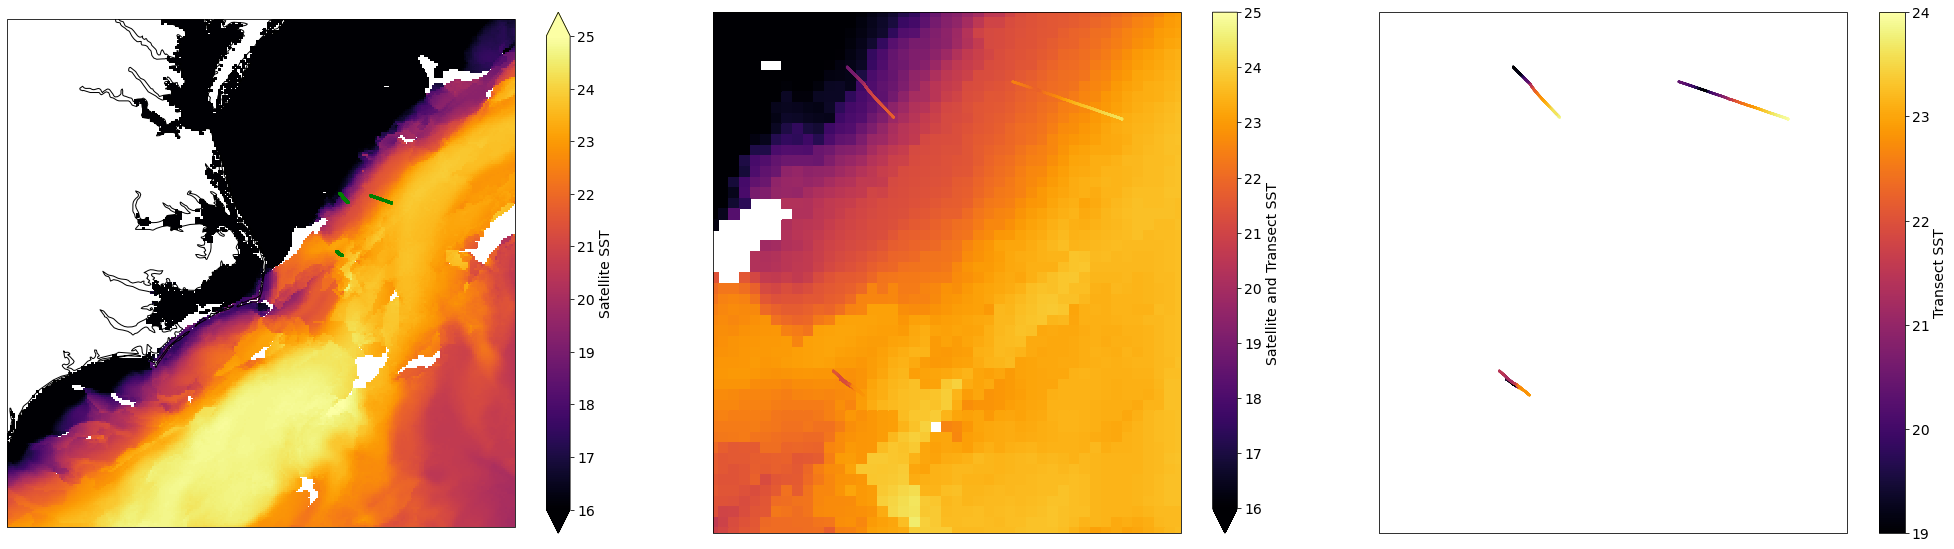

In [121]:
fig, ax = plt.subplots(1,3, figsize=(28,8), subplot_kw=dict(projection=crs.PlateCarree()))
ax[0].coastlines(resolution='10m')       
goes_ds_mean.sea_surface_temperature[:250, 250:500].plot(ax=ax[0], vmin=16, vmax=25, cmap='inferno', cbar_kwargs={'label': 'Satellite SST'})

ax[1].coastlines(resolution='10m')
goes_ds_mean.sea_surface_temperature[80:130, 400:445].plot(ax=ax[1], vmin=16, vmax=25, cmap='inferno', cbar_kwargs={'label': 'Satellite and Transect SST'})

ax[2].coastlines(resolution='10m')
        
        
for i in range(4):
    gdf.loc[start_times[i]:end_times[i]].plot(ax=ax[0], markersize=2, color='green')
    gdf.loc[start_times[i]:end_times[i]].plot(ax=ax[1], markersize=2,column="Temp", cmap='inferno', vmin=16, vmax=25, alpha=1, )#legend=True)

for i in range(3):
    gdf.loc[start_times[i]:end_times[i]].plot(ax=ax[2], markersize=2,column="Temp", cmap='inferno', alpha=1)
gdf.loc[start_times[i+1]:end_times[i+1]].plot(ax=ax[2], markersize=2,column="Temp", cmap='inferno', alpha=1, legend=True, vmin=19, vmax=24, legend_kwds={'label': 'Transect SST'})

ax[0].set_ylim(33.03000259,38.01000214)
ax[0].set_xlim(-77.99000549,-73.01000214)

ax[1].set_ylim(35.43000031,36.40999985)
ax[1].set_xlim(-74.99000549,-74.11000061)

ax[2].set_ylim(35.43000031,36.40999985)
ax[2].set_xlim(-74.99000549,-74.11000061)

fig.tight_layout()
plt.show()    

fig.savefig('march_transects_sst_040822.png',dpi=300)

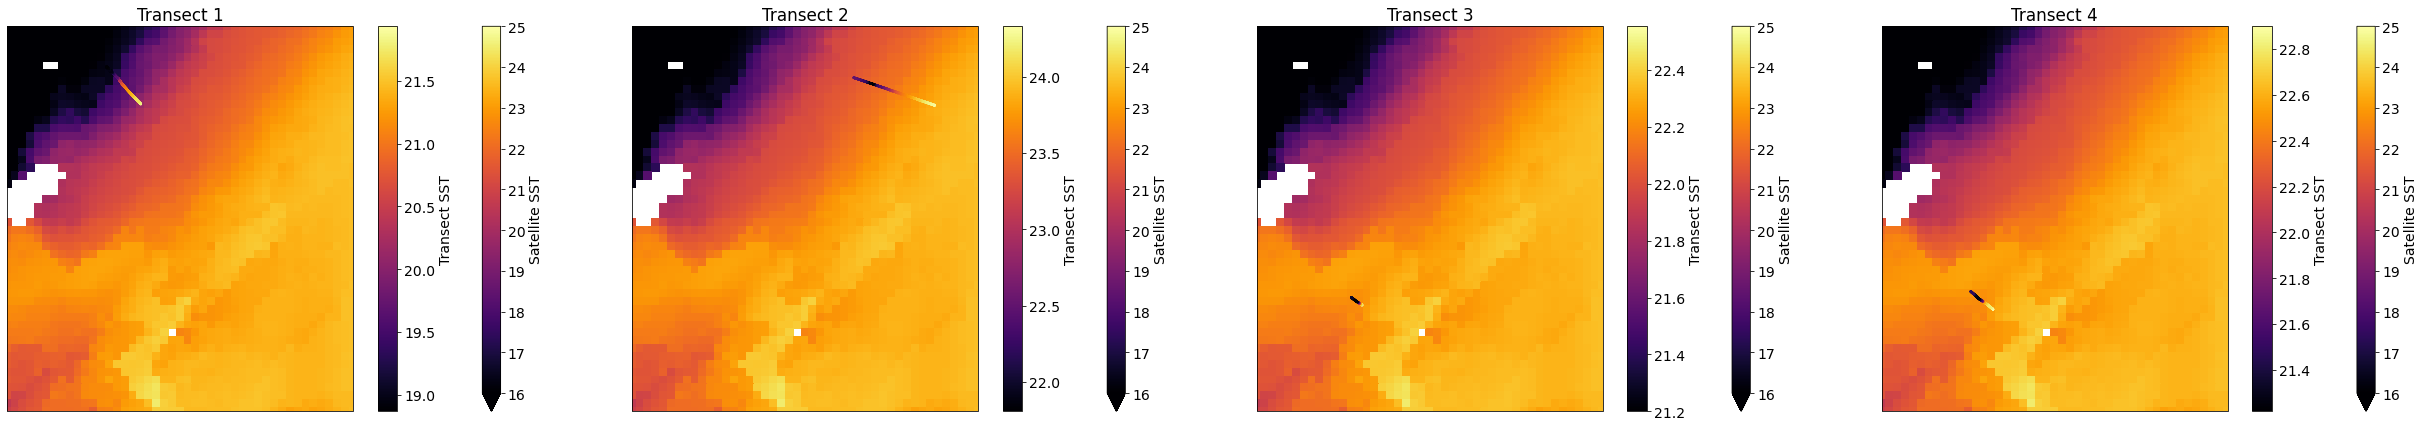

In [119]:
fig, ax = plt.subplots(1,4, figsize=(35,6), subplot_kw=dict(projection=crs.PlateCarree()))

for i in range(4):
    goes_ds_mean.sea_surface_temperature[80:130, 400:445].plot(ax=ax[i], vmin=16, vmax=25, cmap='inferno', cbar_kwargs={'label': 'Satellite SST'})
    ax[i].set_ylim(35.43000031,36.40999985)
    ax[i].set_xlim(-74.99000549,-74.11000061)
    ax[i].set_title('Transect ' + str(i+1))
    gdf.loc[start_times[i]:end_times[i]].plot(ax=ax[i], markersize=2,column="Temp", cmap='inferno', legend=True, legend_kwds={'label': 'Transect SST'})
    
fig.tight_layout()
plt.show()    

fig.savefig('march_individual_transects_sst_040822.png',dpi=300)

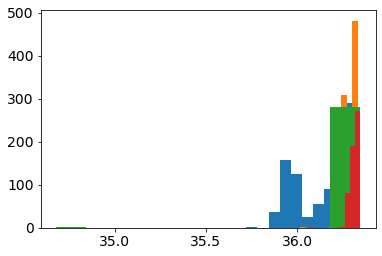

In [106]:
for i in range(4):
    plt.hist(gdf.loc[start_times[i]:end_times[i]].Sal)
plt.show()

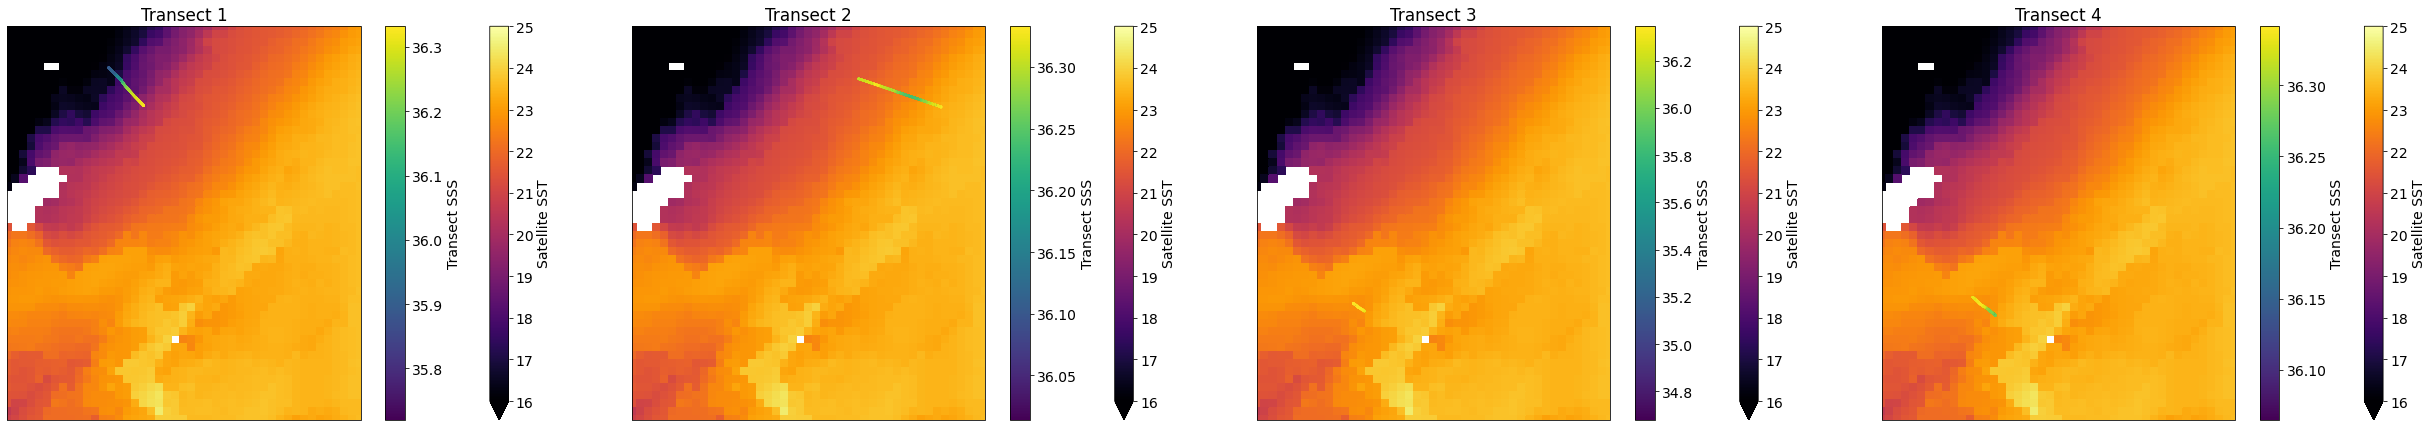

In [118]:
fig, ax = plt.subplots(1,4, figsize=(35,6), subplot_kw=dict(projection=crs.PlateCarree()))

for i in range(4):
    goes_ds_mean.sea_surface_temperature[80:130, 400:445].plot(ax=ax[i], vmin=16, vmax=25, cmap='inferno', cbar_kwargs={'label': 'Satellite SST'})
    ax[i].set_ylim(35.43000031,36.40999985)
    ax[i].set_xlim(-74.99000549,-74.11000061)
    ax[i].set_title('Transect ' + str(i+1))
    gdf.loc[start_times[i]:end_times[i]].plot(ax=ax[i], markersize=2,column="Sal", cmap='viridis', legend=True, legend_kwds={'label': 'Transect SSS'})
    
fig.tight_layout()
plt.show()    

fig.savefig('march_individual_transects_sst_sss_040822.png',dpi=300)

In [377]:
dfs = []
for i in range(len(start_times)):
    dfs.append(tsg_df.loc[start_times[i]:end_times[i]])
tsg_df_subset = pd.concat(dfs)

In [381]:
tsg_df_subset.Temp.min()

18.8657

In [382]:
import gsw

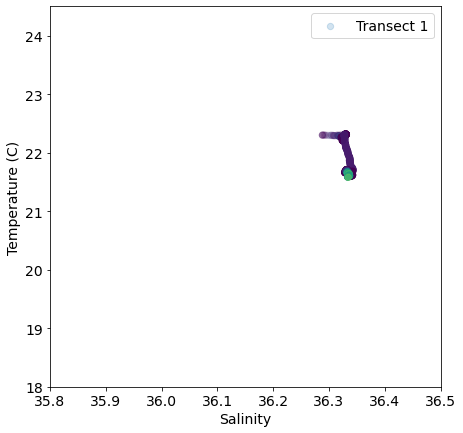

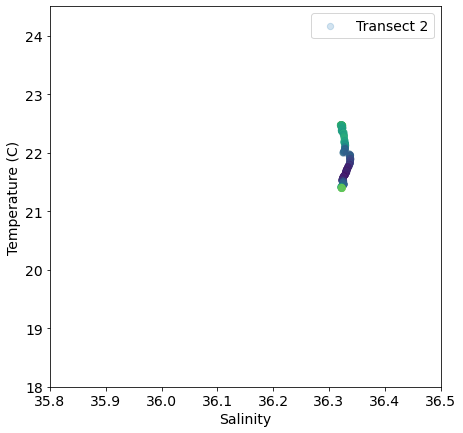

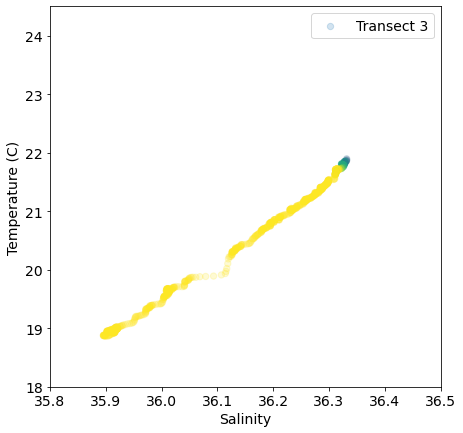

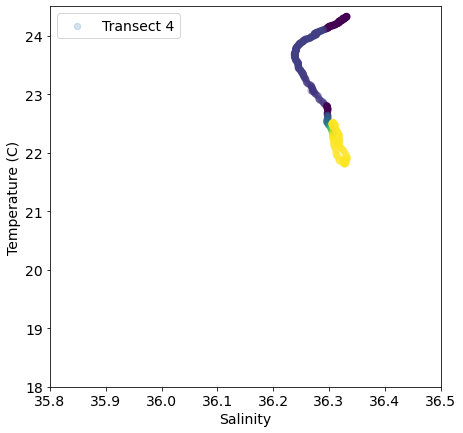

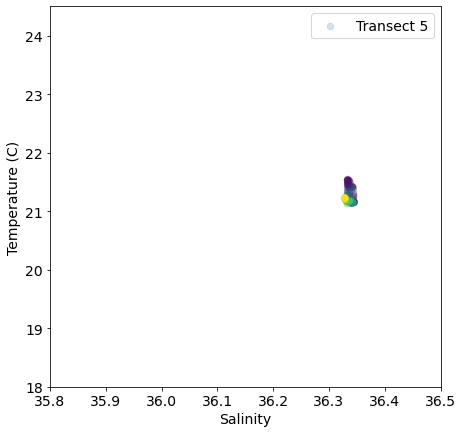

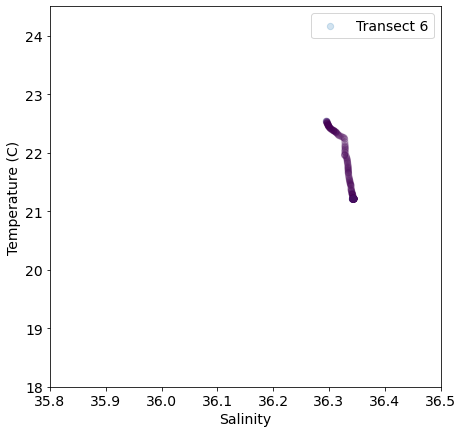

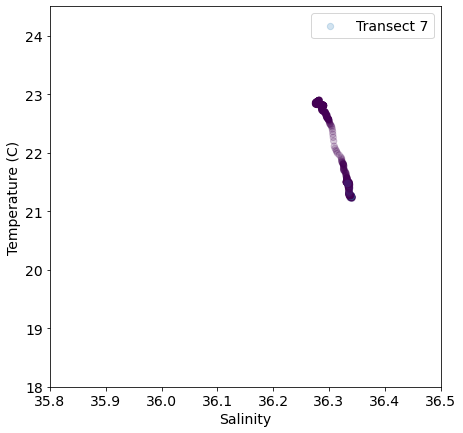

In [395]:
# Figure out boudaries (mins and maxs)
smin = 35.4
smax = 36.5
tmin = 18.3
tmax = 24.2

# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        dens[j,i]=gsw.rho(si[i],ti[j],0)

# Substract 1000 to convert to sigma-t
dens = dens - 1000


for i in range(len(start_times)):
    # plot T and S diagrams first with distance from coast and then with other variables
    fig, ax = plt.subplots(figsize=(7,7))
    markersize=40

    ax.set_xlim(35.8,36.5)
    ax.set_ylim(18,24.5)
    ax.set_xlabel('Salinity')
    ax.set_ylabel('Temperature (C)')

    # CS = a.contour(si,ti,dens, linestyles='dashed', colors='k', alpha=0.5)
    # a.clabel(CS, fontsize=12, inline=1, fmt='%1.1f') # Label every second level
    # ellipse = Ellipse(xy=(35.88, 28.05), width=0.5, height=1.2, angle=-20,
    #                 edgecolor='k', fc='None', ls='--', lw=2)
    # ax.add_patch(ellipse)
    alpha=0.2

    # im = ax.scatter(tsg_df_subset.Sal, tsg_df_subset.Temp, s=markersize,alpha=0.2, c=tsg_df_subset.chla, label='Chla')
    # ax.legend()


    df_subset_full = tsg_df.loc[start_times[i]:end_times[i]]
    im = ax.scatter(df_subset_full.Sal.rolling(window=6).median(), df_subset_full.Temp, c=df_subset_full.chla, vmin=.85,vmax=1.5, s=markersize,alpha=0.2, label='Transect '+str(i+1))
    ax.legend()
    # fig.savefig('figs/simple_t_s_diagram_all_transects.png',dpi=300)
    plt.show()


## Quantify uncertainty in the trios instrument on the SW

In this section I try to quantify uncertainty in the method by using a period where we didn't move much and then propogate that error to the chla measurement.

In [47]:
static_trios_df = trios_df.loc['2021-08-26 19:46:00':'2021-08-26 19:55:00']
len(static_trios_df)

55

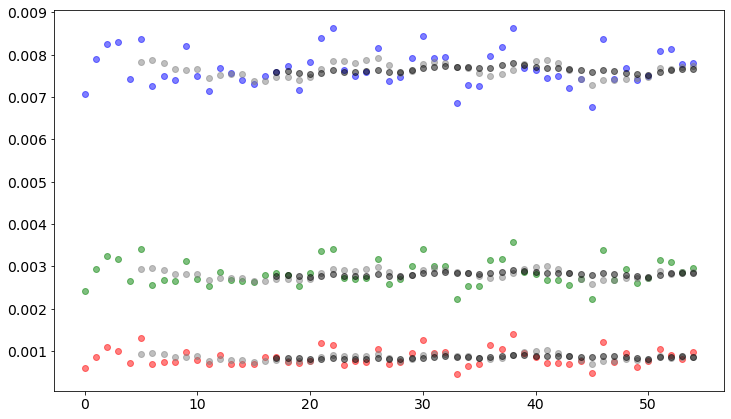

In [48]:
fig, ax = plt.subplots(figsize=(12,7))

for l,u,c in [[156,161,'blue'],[232,240,'green'],[346,351,'red']]:#,[232,240,'green'],[346,351,'red']]:
#     band_mean = static_trios_df.iloc[:, l:u].mean().mean()
#     band_std = static_trios_df.rolling(window=6*3).mean().iloc[:, l:u].mean(axis=1).std()
    
#     ax.axhline(band_mean,color=c)
#     ax.axhline(band_mean+band_std,color=c, ls='--')
#     ax.axhline(band_mean-band_std,color=c, ls='--')


    ax.scatter(range(len(static_trios_df)),static_trios_df.iloc[:, l:u].mean(axis=1),color=c, alpha=0.5)
    ax.scatter(range(len(static_trios_df)),static_trios_df.rolling(window=6).mean().iloc[:, l:u].mean(axis=1),color='grey', alpha=0.5)
    ax.scatter(range(len(static_trios_df)),static_trios_df.rolling(window=6*3).mean().iloc[:, l:u].mean(axis=1),color='black', alpha=0.5)
    
# ax.set_ylim(-0.001,0.004)
plt.show()

Text(0.5, 0, 'Repeated measurement count')

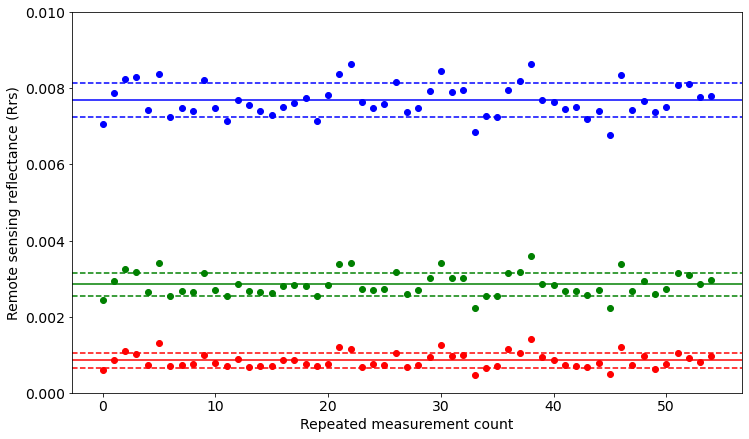

In [51]:
fig, ax = plt.subplots(figsize=(12,7))

for l,u,c in [[156,161,'blue'],[232,240,'green'],[346,351,'red']]:
    band_mean = static_trios_df.iloc[:, l:u].mean().mean()
    band_std = static_trios_df.iloc[:, l:u].mean(axis=1).std()
    
    
    ax.axhline(band_mean,color=c)
    ax.axhline(band_mean+band_std,color=c, ls='--')
    ax.axhline(band_mean-band_std,color=c, ls='--')


    ax.scatter(range(len(static_trios_df)),static_trios_df.iloc[:, l:u].mean(axis=1),color=c, alpha=1)
#     ax.scatter(range(len(static_trios_df)),static_trios_df.rolling(window=6).mean().iloc[:, l:u].mean(axis=1),color='silver', alpha=1)
#     ax.scatter(range(len(static_trios_df)),static_trios_df.rolling(window=6*3).mean().iloc[:, l:u].mean(axis=1),color='black', alpha=1)

ax.set_ylim(0,0.01)

ax.set_ylabel('Remote sensing reflectance (Rrs)')
ax.set_xlabel('Repeated measurement count')
# fig.savefig('repeated_measurements_trios.png',dpi=300)

Text(0.5, 0, 'Repeated measurement count')

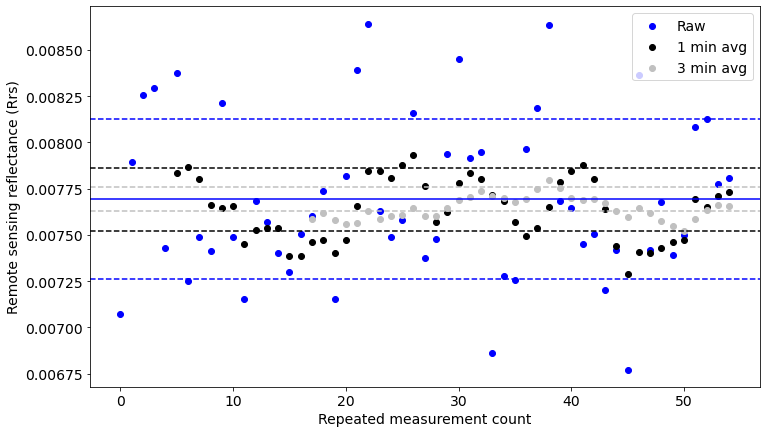

In [53]:
fig, ax = plt.subplots(figsize=(12,7))

for l,u,c in [[156,161,'blue']]:
    band_mean = static_trios_df.iloc[:, l:u].mean().mean()
    ax.axhline(band_mean,color=c)
    
    for i,c_std in [[1,'blue'],[6,'black'],[6*3,'silver']]:
        band_std = static_trios_df.rolling(window=i).mean().iloc[:, l:u].mean(axis=1).std()
        ax.axhline(band_mean+band_std,color=c_std, ls='--')
        ax.axhline(band_mean-band_std,color=c_std, ls='--')


    ax.scatter(range(len(static_trios_df)),static_trios_df.iloc[:, l:u].mean(axis=1),color=c, alpha=1, label='Raw')
    ax.scatter(range(len(static_trios_df)),static_trios_df.rolling(window=6).mean().iloc[:, l:u].mean(axis=1),color='black', alpha=1, label='1 min avg')
    ax.scatter(range(len(static_trios_df)),static_trios_df.rolling(window=6*3).mean().iloc[:, l:u].mean(axis=1),color='silver', alpha=1, label='3 min avg')
ax.legend(loc='upper right')    
ax.set_ylabel('Remote sensing reflectance (Rrs)')
ax.set_xlabel('Repeated measurement count')
# fig.savefig('repeated_measurements_blue_avg.png',dpi=300)

You need the uncertainties package for this.

In [54]:
# pip install --upgrade uncertainties

In [55]:
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.

In [56]:
blue_u = ufloat(static_trios_df.iloc[:, 156:161].mean().mean(), np.std(static_trios_df.iloc[:, 156:161].mean(axis=1).values))
green_u = ufloat(static_trios_df.iloc[:, 232:240].mean().mean(), np.std(static_trios_df.iloc[:, 232:240].mean(axis=1).values))
red_u = ufloat(static_trios_df.iloc[:, 346:351].mean().mean(), np.std(static_trios_df.iloc[:, 346:351].mean(axis=1).values))
blue_u, green_u, red_u

(0.007692916094545454+/-0.0004316484016933594,
 0.002850563672727273+/-0.0003025047880319788,
 0.000854057709090909+/-0.00020191965759646383)

In [57]:
blue_u = ufloat(static_trios_df.iloc[:, 156:161].mean().mean(), np.std(static_trios_df.iloc[:, 156:161].mean(axis=1).values))
green_u = ufloat(static_trios_df.iloc[:, 232:240].mean().mean(), np.std(static_trios_df.iloc[:, 232:240].mean(axis=1).values))
red_u = ufloat(static_trios_df.iloc[:, 346:351].mean().mean(), np.std(static_trios_df.iloc[:, 346:351].mean(axis=1).values))
blue_u, green_u, red_u

(0.007692916094545454+/-0.0004316484016933594,
 0.002850563672727273+/-0.0003025047880319788,
 0.000854057709090909+/-0.00020191965759646383)

Uncertainty based on the group of wavelengths used to calculate chla.

In [59]:
blue_uncert = np.std(static_trios_df.iloc[:, 156:161].mean(axis=1).values)
green_uncert = np.std(static_trios_df.iloc[:, 232:240].mean(axis=1).values)
red_uncert = np.std(static_trios_df.iloc[:, 346:351].mean(axis=1).values)
blue_uncert, green_uncert, red_uncert

(0.0004316484016933594, 0.0003025047880319788, 0.00020191965759646383)

Uncertainty based on a rolling window average of 6 measurements (1 minute)

In [306]:
blue_uncert = np.nanstd(static_trios_df.rolling(window=6).mean().iloc[:, 156:161].mean(axis=1).values)
green_uncert = np.nanstd(static_trios_df.rolling(window=6).mean().iloc[:, 232:240].mean(axis=1).values)
red_uncert = np.nanstd(static_trios_df.rolling(window=6).mean().iloc[:, 346:351].mean(axis=1).values)
blue_uncert, green_uncert, red_uncert

(0.00016776638783025022, 0.00010788283891465276, 7.161309946806462e-05)

In [62]:
chla_uncerts = []

for i in range(len(trios_df)):
    blue_u = ufloat(trios_df.iloc[i, 156:161].mean(), blue_uncert)
    green_u = ufloat(trios_df.iloc[i, 232:240].mean(), green_uncert) 
    red_u = ufloat(trios_df.iloc[i, 346:351].mean(), red_uncert)
    
    chla_u = oc_index(blue_u, green_u, red_u)
    
    chla_uncert = chla_u.s
    chla_uncerts.append(chla_uncert)

Example of calculating uncertainty

In [63]:
blue_u = ufloat(trios_df.iloc[i, 156:161].mean(), blue_uncert)
green_u = ufloat(trios_df.iloc[i, 232:240].mean(), green_uncert) 
red_u = ufloat(trios_df.iloc[i, 346:351].mean(), red_uncert)

chla_u = oc_index(blue_u, green_u, red_u)

In [64]:
trios_df.iloc[i, 156:161].mean(), blue_uncert

(0.0075986914000000004, 0.0004316484016933594)

In [65]:
-260.43*(10**(-.49+191.7*(0.0024-0.59*0.0064-.41*0.00068)))*0.000167

-0.006779260494532654

In [66]:
(441.41*(10**(-.49+191.7*(0.0024-0.59*0.0064-.41*0.00068)))*0.000107)

0.007362084289281303

In [67]:
(-180.98*(10**(-.49+191.7*(0.0024-0.59*0.0064-.41*0.00068)))*0.0000716)

-0.002019846872409247

In [68]:
import math
math.sqrt(0.0068**2+0.0074**2+0.002**2)

0.010246950765959599

In [69]:
blue_u, green_u, red_u

(0.0075986914000000004+/-0.0004316484016933594,
 0.004682888499999999+/-0.0003025047880319788,
 0.0030533482+/-0.00020191965759646383)

In [70]:
chla_u.error_components()

{0.0075986914000000004+/-0.0004316484016933594: 0.022862937692841537,
 0.0030533482+/-0.00020191965759646383: 0.007448298560927712,
 0.004682888499999999+/-0.0003025047880319788: 0.027181268898308585}

In [71]:
chla_u

0.20360693550654468+/-0.03629066615979417

In [72]:
chla_u

0.20360693550654468+/-0.03629066615979417

In [73]:
trios_df['chla_uncert'] = chla_uncerts

<ipython-input-74-779b19d7db1a>:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean(), color='black', lw=3)
<ipython-input-74-779b19d7db1a>:6: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()+static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
<ipython-input-74-779b19d7db1a>:7: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()-static_trios_df.iloc[:, :-2].std(), color='black', ls='--')


Text(0.5, 0, 'Wavelength (nm)')

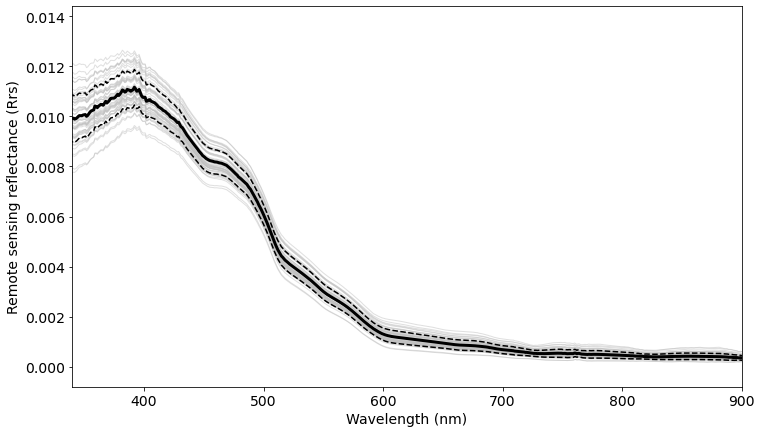

In [74]:
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, 1:-2].values.T, color='silver', lw=1, alpha=0.5)
# ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, 1:-2]+static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
# ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, 1:-2]-static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean(), color='black', lw=3)
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()+static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()-static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
ax.set_xlim(340,900)
ax.set_ylabel('Remote sensing reflectance (Rrs)')
ax.set_xlabel('Wavelength (nm)')
# fig.savefig('spectrum_repeated.png',dpi=300)

(340.0, 900.0)

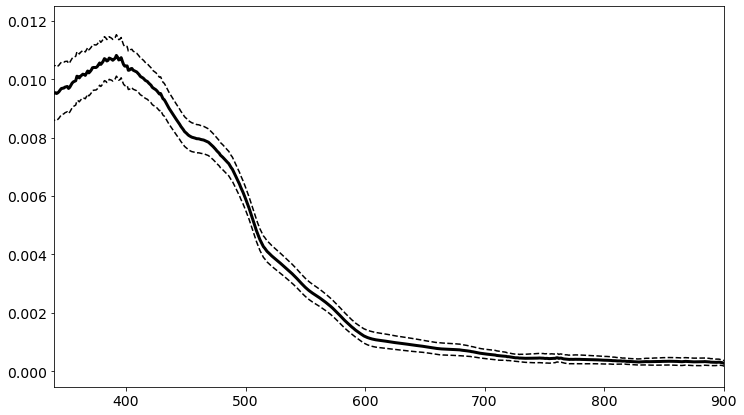

In [75]:
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[50, 1:-2], color='black', lw=3)
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[50, 1:-2]+static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[50, 1:-2]-static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
ax.set_xlim(340,900)


<ipython-input-76-f8aafffdfa3d>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean(), color='black', lw=3)
<ipython-input-76-f8aafffdfa3d>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()+static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
<ipython-input-76-f8aafffdfa3d>:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()-static_trios_df.iloc[:, :-2].std(), color='black', ls='--')


(340.0, 900.0)

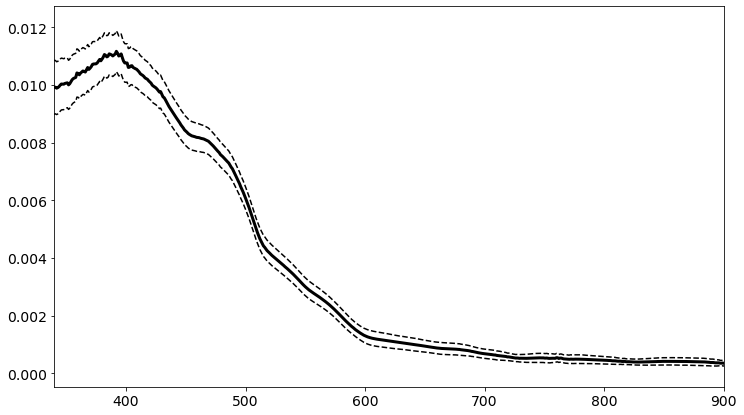

In [76]:
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean(), color='black', lw=3)
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()+static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()-static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
ax.set_xlim(340,900)


### Now look at this on a specific transect

In [29]:
transect = 2
df_transect = df.loc[start_times[transect]:end_times[transect]]
trios_df_transect = trios_df.loc[start_times[transect]:end_times[transect]]
cdom_df_transect = cdom_df.loc[start_times[transect]:end_times[transect]]

Text(0.5, 1.0, '')

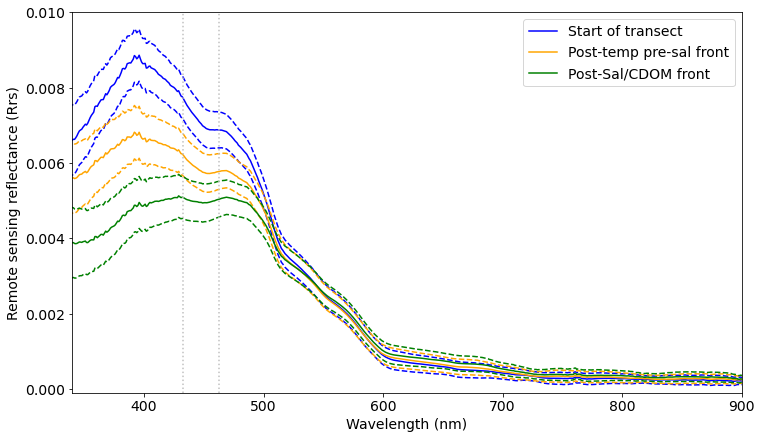

In [79]:
fig,ax = plt.subplots(figsize=(12,7))
ax.plot(static_trios_df.columns[1:-2].astype(int),trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2],label='Start of transect', color='blue',)
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2]+static_trios_df.iloc[:, :-2].std(), color='blue', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2]-static_trios_df.iloc[:, :-2].std(), color='blue', ls='--')


# trios_df_transect.loc['2021-08-27 16:37:00':'2021-08-27 16:43:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-temp front')
# trios_df_transect.loc['2021-08-27 16:48:00':'2021-08-27 16:53:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-temp front')
# trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-Sal/CDOM front')


# trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-temp pre-sal front')
ax.plot(static_trios_df.columns[1:-2].astype(int),trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2],label='Post-temp pre-sal front', color='orange',)
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2]+static_trios_df.iloc[:, :-2].std(), color='orange', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2]-static_trios_df.iloc[:, :-2].std(), color='orange', ls='--')



ax.plot(static_trios_df.columns[1:-2].astype(int),trios_df_transect.loc['2021-08-27 17:34:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2],label='Post-Sal/CDOM front',  color='green', )
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 17:34:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2]+static_trios_df.iloc[:, :-2].std(), color='green', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 17:34:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2]-static_trios_df.iloc[:, :-2].std(), color='green', ls='--')


ax.axvline(443-10, color='silver', ls='dotted')
ax.axvline(443+20, color='silver', ls='dotted')

ax.legend()
ax.set_ylabel('Remote sensing reflectance (Rrs)')
ax.set_xlabel('Wavelength (nm)')

ax.set_xlim(340,900)
ax.set_ylim(-0.0001,0.01)

ax.set_title('')


# plt.savefig('radiometry_spectra_across_front.png',dpi=300)


(-0.0001, 0.01)

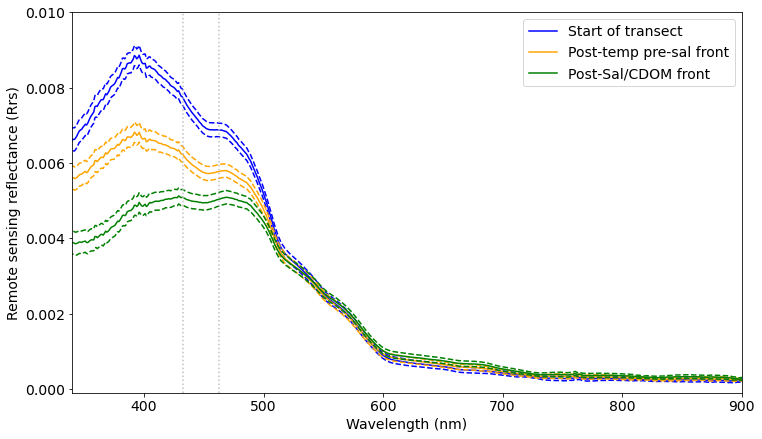

In [80]:
fig,ax = plt.subplots(figsize=(12,7))
ax.plot(static_trios_df.columns[1:-2].astype(int),trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2],label='Start of transect', color='blue',)
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2]+static_trios_df.rolling(6).mean().iloc[:, :-2].std(), color='blue', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2]-static_trios_df.rolling(6).mean().iloc[:, :-2].std(), color='blue', ls='--')


# trios_df_transect.loc['2021-08-27 16:37:00':'2021-08-27 16:43:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-temp front')
# trios_df_transect.loc['2021-08-27 16:48:00':'2021-08-27 16:53:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-temp front')
# trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-Sal/CDOM front')

# trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-temp pre-sal front')
ax.plot(static_trios_df.columns[1:-2].astype(int),trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2],label='Post-temp pre-sal front', color='orange',)
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2]+static_trios_df.rolling(6).mean().iloc[:, :-2].std(), color='orange', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2]-static_trios_df.rolling(6).mean().iloc[:, :-2].std(), color='orange', ls='--')



ax.plot(static_trios_df.columns[1:-2].astype(int),trios_df_transect.loc['2021-08-27 17:34:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2],label='Post-Sal/CDOM front',  color='green', )
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 17:34:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2]+static_trios_df.rolling(6).mean().iloc[:, :-2].std(), color='green', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 17:34:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2]-static_trios_df.rolling(6).mean().iloc[:, :-2].std(), color='green', ls='--')


ax.axvline(443-10, color='silver', ls='dotted')
ax.axvline(443+20, color='silver', ls='dotted')

ax.legend()
ax.set_ylabel('Remote sensing reflectance (Rrs)')
ax.set_xlabel('Wavelength (nm)')

ax.set_xlim(340,900)
ax.set_ylim(-0.0001,0.01)



# plt.savefig('radiometry_spectra_across_front_binned.png',dpi=300)


In [81]:
start_times[transect]

'2021-08-27 16:09:00'

In [82]:
end_times[transect]

'2021-08-27 17:40:00'

In [83]:
plt.rcParams.update({'font.size': 16})

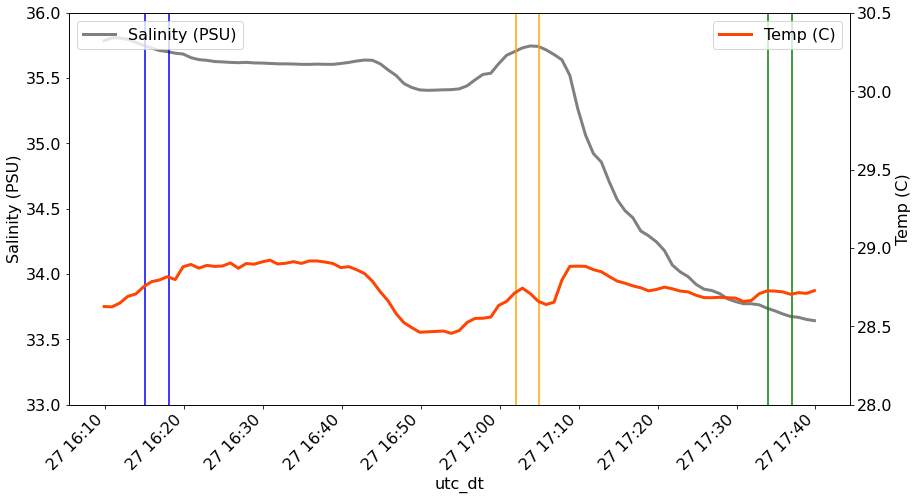

In [84]:
fig, ax = plt.subplots(figsize=(14,8))

df_transect.plot(y='TSG--sal',ax=ax, linewidth=3, color='grey', label='Salinity (PSU)')
ax.set_ylim(33,36)

ax1 = ax.twinx()
df_transect.plot(y='TSG--temp-SBE38',ax=ax1, linewidth=3, color='orangered', label='Temp (C)')
ax1.set_ylim(28,30.5)

ax.axvline('2021-08-27 16:15:00',color='blue')
ax.axvline('2021-08-27 16:18:00',color='blue')

ax.axvline('2021-08-27 17:02:00',color='orange')
ax.axvline('2021-08-27 17:05:00',color='orange')

ax.axvline('2021-08-27 17:34:00',color='green')
ax.axvline('2021-08-27 17:37:00',color='green')

ax.legend(loc='upper left')
ax1.legend(loc='upper right')
ax.set_ylabel('Salinity (PSU)')
ax1.set_ylabel('Temp (C)')

# ax.set_ylim(0.000,0.012)
fig.autofmt_xdate(rotation=45)
# fig.savefig('sal_temp_front.png')

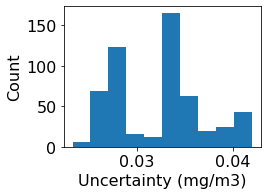

In [86]:
fig, ax = plt.subplots(figsize=(4,3))
ax.hist(trios_df_transect['chla_uncert'])
ax.set_ylabel('Count')
ax.set_xlabel('Uncertainty (mg/m3)')
fig.tight_layout()
# fig.savefig('uncertanty_distribution.png',dpi=300)

In [87]:
trios_df_transect['chla_oci']

utc_dt
2021-08-27 16:09:00    0.151699
2021-08-27 16:09:10    0.153381
2021-08-27 16:09:20    0.151364
2021-08-27 16:09:30    0.147087
2021-08-27 16:09:40    0.149037
                         ...   
2021-08-27 17:39:20    0.232420
2021-08-27 17:39:30    0.227189
2021-08-27 17:39:40    0.233379
2021-08-27 17:39:50    0.235517
2021-08-27 17:40:00    0.221562
Name: chla_oci, Length: 541, dtype: float64

The uncertainty is basically proportional to the chla

In [88]:
np.unique(trios_df_transect['chla_uncert']/trios_df_transect['chla_oci'])

array([0.17823885, 0.17823885, 0.17823885, 0.17823885])

In [325]:
trios_df_transect['chla_oci']

utc_dt
2021-08-27 16:09:00    0.151699
2021-08-27 16:09:10    0.153381
2021-08-27 16:09:20    0.151364
2021-08-27 16:09:30    0.147087
2021-08-27 16:09:40    0.149037
                         ...   
2021-08-27 17:39:20    0.232420
2021-08-27 17:39:30    0.227189
2021-08-27 17:39:40    0.233379
2021-08-27 17:39:50    0.235517
2021-08-27 17:40:00    0.221562
Name: chla_oci, Length: 541, dtype: float64

In [89]:
trios_df_transect['chla_uncert']

utc_dt
2021-08-27 16:09:00    0.027039
2021-08-27 16:09:10    0.027338
2021-08-27 16:09:20    0.026979
2021-08-27 16:09:30    0.026217
2021-08-27 16:09:40    0.026564
                         ...   
2021-08-27 17:39:20    0.041426
2021-08-27 17:39:30    0.040494
2021-08-27 17:39:40    0.041597
2021-08-27 17:39:50    0.041978
2021-08-27 17:40:00    0.039491
Name: chla_uncert, Length: 541, dtype: float64

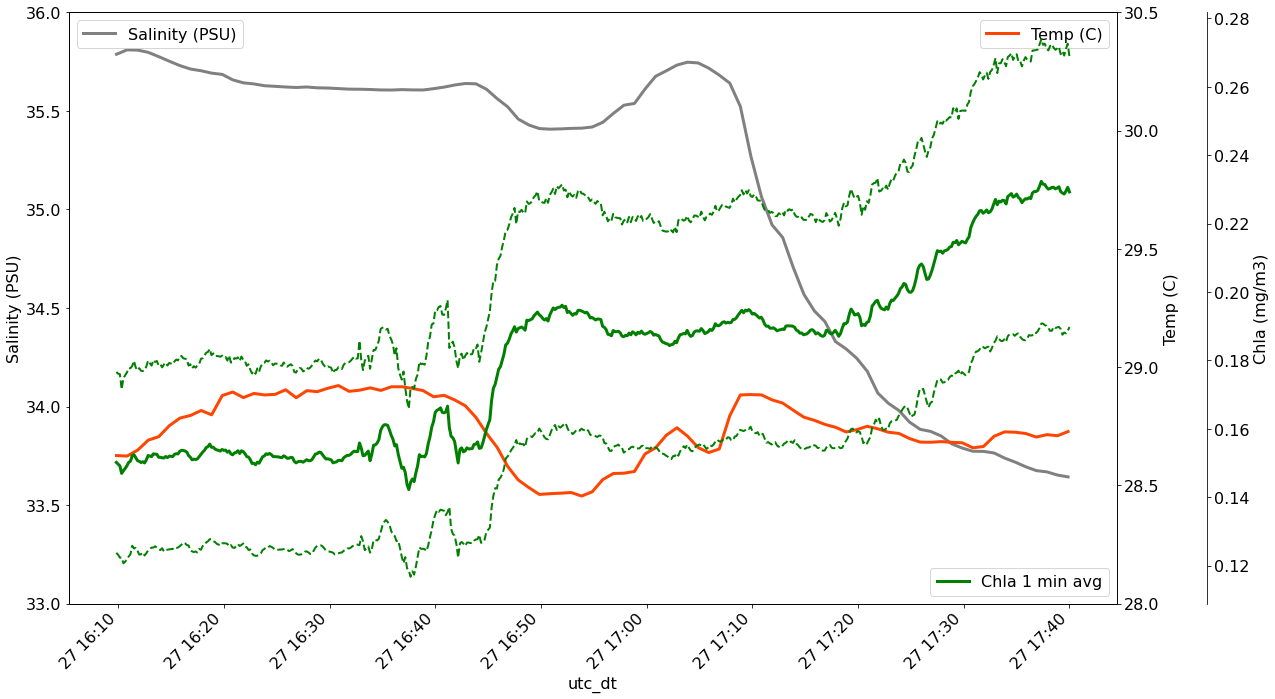

In [90]:
fig, ax = plt.subplots(figsize=(18,10))

df_transect.plot(y='TSG--sal',ax=ax, linewidth=3, color='grey', label='Salinity (PSU)')
ax.set_ylim(33,36)

ax1 = ax.twinx()
df_transect.plot(y='TSG--temp-SBE38',ax=ax1, linewidth=3, color='orangered', label='Temp (C)')
ax1.set_ylim(28,30.5)

ax2 = ax.twinx()

trios_df_transect['chla_oci'].rolling(window=6).mean().plot(ax=ax2, color='green', label='Chla 1 min avg', linewidth=3)
(trios_df_transect['chla_oci'].rolling(window=6).mean()-trios_df_transect['chla_uncert']).plot(ax=ax2, color='green', label='', linewidth=2, ls='--')
(trios_df_transect['chla_oci'].rolling(window=6).mean()+trios_df_transect['chla_uncert']).plot(ax=ax2, color='green', label='', linewidth=2, ls='--')

# ax.axvline('2021-08-27 16:15:00',color='blue')
# ax.axvline('2021-08-27 16:18:00',color='blue')

# ax.axvline('2021-08-27 17:02:00',color='orange')
# ax.axvline('2021-08-27 17:05:00',color='orange')

# ax.axvline('2021-08-27 17:34:00',color='green')
# ax.axvline('2021-08-27 17:37:00',color='green')

ax.legend(loc='upper left')
ax1.legend(loc='upper right')
ax2.legend(loc='lower right')

ax.set_ylabel('Salinity (PSU)')
ax1.set_ylabel('Temp (C)')
ax2.set_ylabel('Chla (mg/m3)')

ax2.spines['right'].set_position(('outward', 90))

# ax.set_ylim(0.000,0.012)
fig.autofmt_xdate(rotation=45)
fig.tight_layout()
# fig.savefig('chla_uncert_sal_temp.png')

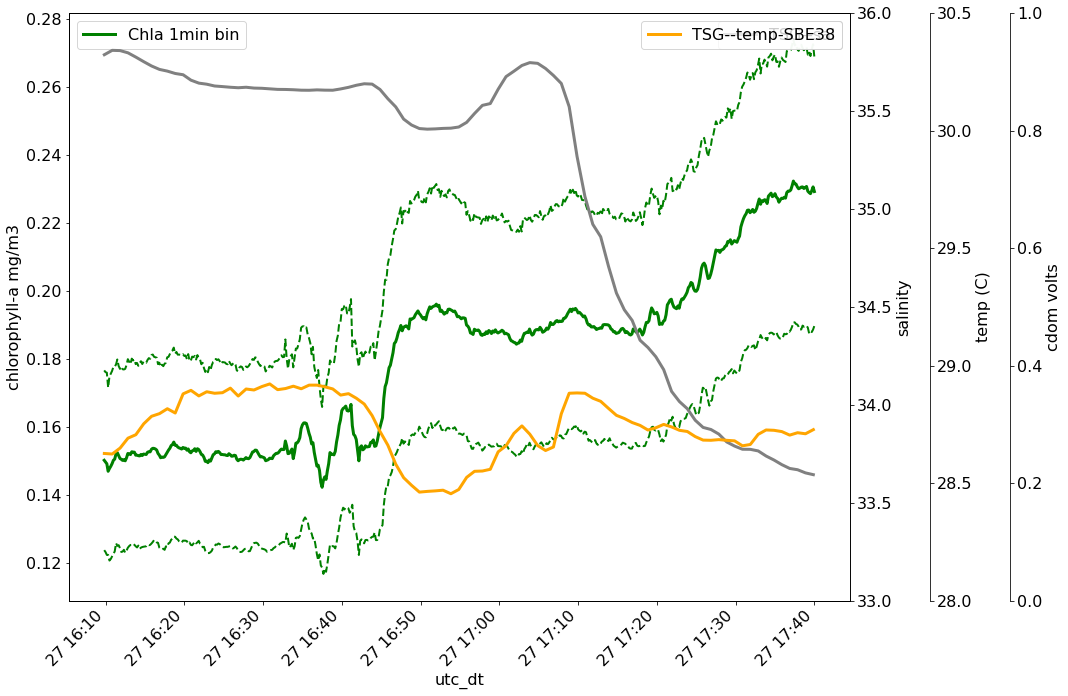

In [91]:
fig, ax = plt.subplots(figsize=(14,12))

ax2 = ax.twinx()
ax3 = ax.twinx()
ax4 = ax.twinx()

ax3.spines['right'].set_position(('outward', 80))
ax4.spines['right'].set_position(('outward', 160))


df_transect.plot(y='TSG--sal',ax=ax2, linewidth=3, color='grey')
ax2.set_ylim(33,36)

df_transect.plot(y='TSG--temp-SBE38',ax=ax3, linewidth=3, color='orange')
ax3.set_ylim(28,30.5)

trios_df_transect['chla_oci'].rolling(window=6).mean().plot(ax=ax, color='green', label='Chla 1min bin', linewidth=3)
(trios_df_transect['chla_oci'].rolling(window=6).mean()-trios_df_transect['chla_uncert']).plot(ax=ax, color='green', label='', linewidth=2, ls='--')
(trios_df_transect['chla_oci'].rolling(window=6).mean()+trios_df_transect['chla_uncert']).plot(ax=ax, color='green', label='', linewidth=2, ls='--')

ax.legend(loc='upper left')
ax.set_ylabel('chlorophyll-a mg/m3')
ax2.set_ylabel('salinity')
ax3.set_ylabel('temp (C)')
ax4.set_ylabel('cdom volts')


# ax.set_ylim(0.000,0.012)
fig.autofmt_xdate(rotation=45)
# fig.savefig('chla_uncert_sal_temp.png')

### Explore the radiometer data a bit more

Checking out and clustering a transect

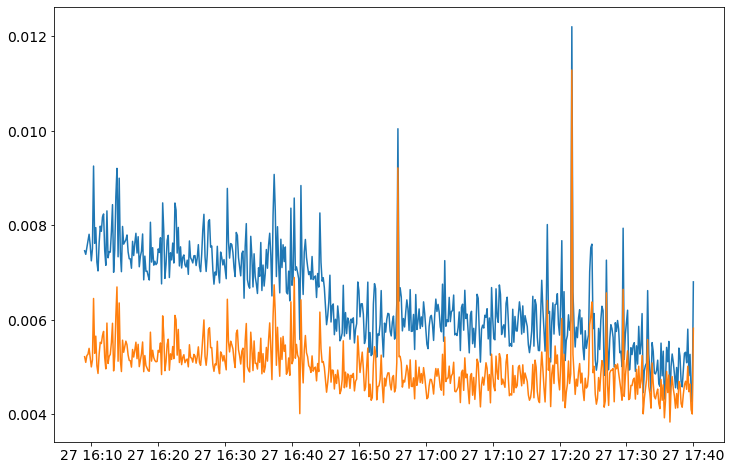

In [79]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(trios_df_transect['440'].rolling(window=1).mean())
ax.plot(trios_df_transect['500'].rolling(window=1).mean())


In [317]:
len(start_times)

13

In [34]:
transect = 12
df_transect = df.loc[start_times[transect]:end_times[transect]]
trios_df_transect = trios_df.loc[start_times[transect]:end_times[transect]]
cdom_df_transect = cdom_df.loc[start_times[transect]:end_times[transect]]


In [35]:
# Calculate rolling median
rolling_440 = trios_df_transect['440'].rolling(window=6*2).median()
upper_threshold = 0.0005
lower_threshold = -0.0005

# all in one line 
df_filtered = trios_df_transect.drop(trios_df_transect[(trios_df_transect['440']-rolling_440>upper_threshold)|(trios_df_transect['440']- rolling_440<lower_threshold)].index) 
# if you want to drop the column as well
# del df["rolling_temp"]

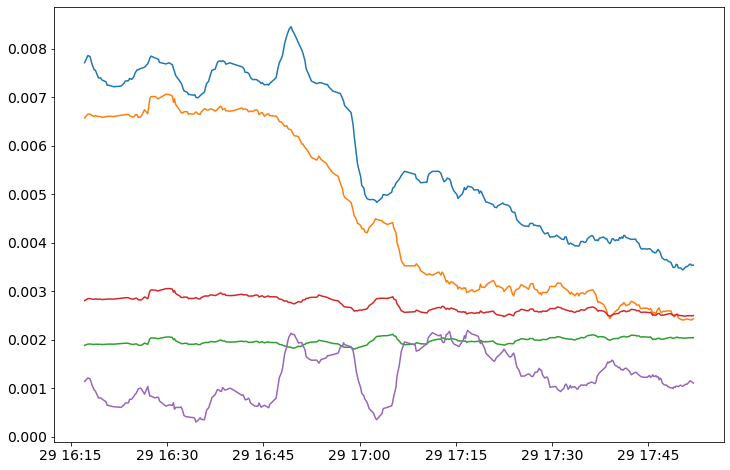

In [36]:
fig, ax = plt.subplots(figsize=(12,8))
# ax.plot(trios_df_transect['440'].rolling(window=1).mean())
# ax.plot(trios_df_transect['460'].rolling(window=1).mean())
# ax.plot(trios_df_transect['440'].rolling(window=6*3).mean())
# ax.plot(df_filtered['440'])
ax.plot(df_filtered['440'].rolling(window=6*2).mean())
ax.plot(df_filtered['440'].rolling(window=6*2).mean()-df_filtered['660'].rolling(window=6*2).mean())
ax.plot(df_filtered['550'].rolling(window=6*2).mean()-df_filtered['660'].rolling(window=6*2).mean())

ax.plot(df_filtered['520'].rolling(window=6*2).mean()-df_filtered['660'].rolling(window=6*2).mean())


ax.plot(df_filtered['660'].rolling(window=6*2).mean())

# ax.set_ylim(0.002,0.01)
# trios_df_transect.plot('440')

In [37]:
df_filtered.iloc[:,1:-2]

320       321       322       323       324  \
utc_dt                                                                  
2021-08-29 16:15:10  0.005114  0.005222  0.005263  0.005213  0.005151   
2021-08-29 16:15:20  0.005856  0.005944  0.005960  0.005886  0.005808   
2021-08-29 16:15:30  0.007062  0.007106  0.007089  0.007012  0.006933   
2021-08-29 16:15:40  0.006130  0.006210  0.006234  0.006173  0.006105   
2021-08-29 16:15:50  0.006626  0.006690  0.006703  0.006633  0.006552   
...                       ...       ...       ...       ...       ...   
2021-08-29 17:50:50  0.003403  0.003446  0.003451  0.003403  0.003342   
2021-08-29 17:51:00  0.003165  0.003203  0.003202  0.003158  0.003104   
2021-08-29 17:51:30  0.003332  0.003375  0.003376  0.003336  0.003281   
2021-08-29 17:51:40  0.002666  0.002694  0.002687  0.002651  0.002599   
2021-08-29 17:52:00  0.004100  0.004148  0.004151  0.004094  0.004020   

                          325       326       327       328       329  ...  \
utc_dt                                                                 ...   
2021-08-29 16:15:10  0.005104  0.005136  0.005065  0.004927  0.004996  ...   
2021-08-29 16:15:20  0.005748  0.005771  0.005692  0.005550  0.005628  ...   
2021-08-29 16:15:30  0.006873  0.006898  0.006812  0.006656  0.006719  ...   
2021-08-29 16:15:40  0.006053  0.006076  0.005999  0.005859  0.005925  ...   
2021-08-29 16:15:50  0.006487  0.006513  0.006442  0.006306  0.006369  ...   
...                       ...       ...       ...       ...       ...  ...   
2021-08-29 17:50:50  0.003295  0.003297  0.003224  0.003109  0.003144  ...   
2021-08-29 17:51:00  0.003064  0.003071  0.003000  0.002887  0.002922  ...   
2021-08-29 17:51:30  0.003240  0.003246  0.003172  0.003055  0.003089  ...   
2021-08-29 17:51:40  0.002559  0.002560  0.002492  0.002386  0.002422  ...   
2021-08-29 17:52:00  0.003961  0.003962  0.003878  0.003743  0.003773  ...   

                          941       942       943       944       945  \
utc_dt                                                                  
2021-08-29 16:15:10 -0.000540 -0.000588 -0.000501 -0.000380 -0.000261   
2021-08-29 16:15:20  0.000032 -0.000098  0.000016  0.000121  0.000225   
2021-08-29 16:15:30  0.000774  0.000721  0.000598  0.000537  0.000477   
2021-08-29 16:15:40  0.000475  0.000510  0.000535  0.000505  0.000473   
2021-08-29 16:15:50 -0.000072 -0.000043  0.000073  0.000190  0.000306   
...                       ...       ...       ...       ...       ...   
2021-08-29 17:50:50  0.000499  0.000532  0.000503  0.000487  0.000472   
2021-08-29 17:51:00  0.000216  0.000156  0.000135  0.000163  0.000192   
2021-08-29 17:51:30  0.001219  0.001187  0.001195  0.001245  0.001295   
2021-08-29 17:51:40  0.000615  0.000608  0.000652  0.000668  0.000681   
2021-08-29 17:52:00 -0.000191 -0.000196 -0.000262 -0.000326 -0.000389   

                          946       947       948       949       950  
utc_dt                                                                 
2021-08-29 16:15:10 -0.000355 -0.000570 -0.000821 -0.000906 -0.000869  
2021-08-29 16:15:20  0.000099 -0.000029 -0.000143 -0.000068  0.000041  
2021-08-29 16:15:30  0.000580  0.000604  0.000588  0.000598  0.000657  
2021-08-29 16:15:40  0.000465  0.000465  0.000468  0.000540  0.000640  
2021-08-29 16:15:50  0.000350  0.000381  0.000411  0.000389  0.000327  
...                       ...       ...       ...       ...       ...  
2021-08-29 17:50:50  0.000479  0.000473  0.000461  0.000465  0.000468  
2021-08-29 17:51:00  0.000211  0.000224  0.000234  0.000240  0.000236  
2021-08-29 17:51:30  0.001343  0.001358  0.001360  0.001333  0.001300  
2021-08-29 17:51:40  0.000725  0.000757  0.000782  0.000729  0.000647  
2021-08-29 17:52:00 -0.000361 -0.000335 -0.000314 -0.000278 -0.000241  

[344 rows x 631 columns]

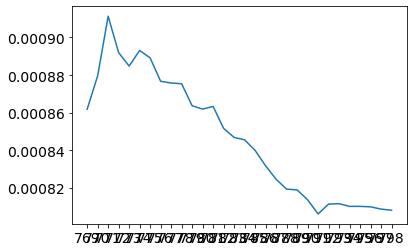

In [38]:
plt.plot(df_filtered.iloc[:,450:480].mean())

In [39]:
corrected_specs = []
for i in range(len(df_filtered.iloc[:,1:-2])):
    corrected_specs.append(df_filtered.iloc[i,1:-2] - df_filtered.iloc[i,450:480].mean())

In [40]:
corrected_specs = pd.DataFrame(corrected_specs, columns=df_filtered.columns[1:-2] )

In [41]:
corrected_specs['chla_oci'] = oc_index(corrected_specs.iloc[:, 156:161].mean(axis=1).values, corrected_specs.iloc[:, 232:240].mean(axis=1).values, corrected_specs.iloc[:, 346:351].mean(axis=1).values)

In [42]:
corrected_specs['TimeStamp'] = df_filtered['TimeStamp']

<AxesSubplot:xlabel='utc_dt'>

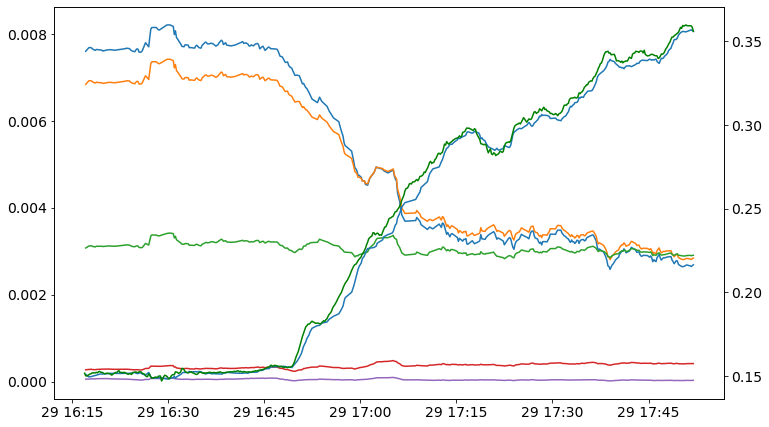

In [43]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(corrected_specs['420'].rolling(window=6*2).mean())
ax.plot(corrected_specs['440'].rolling(window=6*2).mean())

ax.plot(corrected_specs['520'].rolling(window=6*2).mean())


ax.plot(corrected_specs['660'].rolling(window=6*2).mean())
ax.plot(corrected_specs['750'].rolling(window=6*2).mean())

ax2 = ax.twinx()
ax2.plot(corrected_specs['chla_oci'].rolling(window=6*2).mean())
trios_df_transect['chla_oci'].rolling(window=6*2).mean().plot(ax=ax2, color='green')

# ax.set_ylim(0.002,0.01)
# trios_df_transect.plot('440')

In [100]:
trios_df_transect

TimeStamp       320       321       322  \
utc_dt                                                                  
2021-08-29 16:15:10  8/29/2021 12:15:10  0.005114  0.005222  0.005263   
2021-08-29 16:15:20  8/29/2021 12:15:20  0.005856  0.005944  0.005960   
2021-08-29 16:15:30  8/29/2021 12:15:30  0.007062  0.007106  0.007089   
2021-08-29 16:15:40  8/29/2021 12:15:40  0.006130  0.006210  0.006234   
2021-08-29 16:15:50  8/29/2021 12:15:50  0.006626  0.006690  0.006703   
...                                 ...       ...       ...       ...   
2021-08-29 17:51:20  8/29/2021 13:51:20  0.004854  0.004898  0.004895   
2021-08-29 17:51:30  8/29/2021 13:51:30  0.003332  0.003375  0.003376   
2021-08-29 17:51:40  8/29/2021 13:51:40  0.002666  0.002694  0.002687   
2021-08-29 17:51:50  8/29/2021 13:51:50  0.004869  0.004917  0.004919   
2021-08-29 17:52:00  8/29/2021 13:52:00  0.004100  0.004148  0.004151   

                          323       324       325       326       327  \
utc_dt                                                                  
2021-08-29 16:15:10  0.005213  0.005151  0.005104  0.005136  0.005065   
2021-08-29 16:15:20  0.005886  0.005808  0.005748  0.005771  0.005692   
2021-08-29 16:15:30  0.007012  0.006933  0.006873  0.006898  0.006812   
2021-08-29 16:15:40  0.006173  0.006105  0.006053  0.006076  0.005999   
2021-08-29 16:15:50  0.006633  0.006552  0.006487  0.006513  0.006442   
...                       ...       ...       ...       ...       ...   
2021-08-29 17:51:20  0.004826  0.004736  0.004664  0.004668  0.004576   
2021-08-29 17:51:30  0.003336  0.003281  0.003240  0.003246  0.003172   
2021-08-29 17:51:40  0.002651  0.002599  0.002559  0.002560  0.002492   
2021-08-29 17:51:50  0.004839  0.004745  0.004670  0.004682  0.004604   
2021-08-29 17:52:00  0.004094  0.004020  0.003961  0.003962  0.003878   

                          328  ...       943       944       945       946  \
utc_dt                         ...                                           
2021-08-29 16:15:10  0.004927  ... -0.000501 -0.000380 -0.000261 -0.000355   
2021-08-29 16:15:20  0.005550  ...  0.000016  0.000121  0.000225  0.000099   
2021-08-29 16:15:30  0.006656  ...  0.000598  0.000537  0.000477  0.000580   
2021-08-29 16:15:40  0.005859  ...  0.000535  0.000505  0.000473  0.000465   
2021-08-29 16:15:50  0.006306  ...  0.000073  0.000190  0.000306  0.000350   
...                       ...  ...       ...       ...       ...       ...   
2021-08-29 17:51:20  0.004427  ...  0.001078  0.001156  0.001232  0.001153   
2021-08-29 17:51:30  0.003055  ...  0.001195  0.001245  0.001295  0.001343   
2021-08-29 17:51:40  0.002386  ...  0.000652  0.000668  0.000681  0.000725   
2021-08-29 17:51:50  0.004466  ...  0.002200  0.002370  0.002538  0.002440   
2021-08-29 17:52:00  0.003743  ... -0.000262 -0.000326 -0.000389 -0.000361   

                          947       948       949       950  \
utc_dt                                                        
2021-08-29 16:15:10 -0.000570 -0.000821 -0.000906 -0.000869   
2021-08-29 16:15:20 -0.000029 -0.000143 -0.000068  0.000041   
2021-08-29 16:15:30  0.000604  0.000588  0.000598  0.000657   
2021-08-29 16:15:40  0.000465  0.000468  0.000540  0.000640   
2021-08-29 16:15:50  0.000381  0.000411  0.000389  0.000327   
...                       ...       ...       ...       ...   
2021-08-29 17:51:20  0.001040  0.000924  0.000928  0.001006   
2021-08-29 17:51:30  0.001358  0.001360  0.001333  0.001300   
2021-08-29 17:51:40  0.000757  0.000782  0.000729  0.000647   
2021-08-29 17:51:50  0.002279  0.002108  0.002110  0.002233   
2021-08-29 17:52:00 -0.000335 -0.000314 -0.000278 -0.000241   

                               datetime  chla_oci  
utc_dt                                             
2021-08-29 16:15:10 2021-08-29 12:15:10  0.169043  
2021-08-29 16:15:20 2021-08-29 12:15:20  0.150944  
2021-08-29 16:15:30 2021-08-29 12:15:30  0.150044  
2021-08-29 16:15:40 2021-08-29 12:1

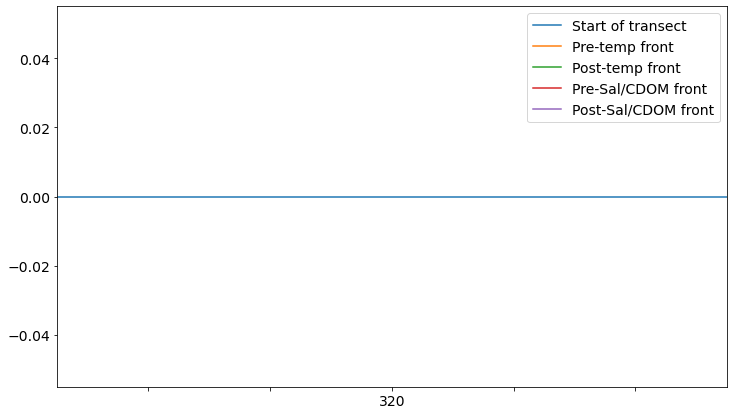

In [96]:
fig,ax = plt.subplots(figsize=(12,7))
trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2].plot(label='Start of transect')

trios_df_transect.loc['2021-08-27 16:37:00':'2021-08-27 16:43:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-temp front')
trios_df_transect.loc['2021-08-27 16:48:00':'2021-08-27 16:53:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-temp front')
trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-Sal/CDOM front')
trios_df_transect.loc['2021-08-27 17:23:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-Sal/CDOM front')

ax.axhline(0)

ax.legend()
# plt.savefig('radiometry_spectra.png')


In [ ]:
fig,ax = plt.subplots(figsize=(12,7))
trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2].plot(label='Start of transect')

trios_df_transect.loc['2021-08-27 16:37:00':'2021-08-27 16:43:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-temp front')
trios_df_transect.loc['2021-08-27 16:48:00':'2021-08-27 16:53:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-temp front')
trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-Sal/CDOM front')
trios_df_transect.loc['2021-08-27 17:23:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-Sal/CDOM front')

ax.axhline(0)

ax.legend()
# plt.savefig('radiometry_spectra.png')


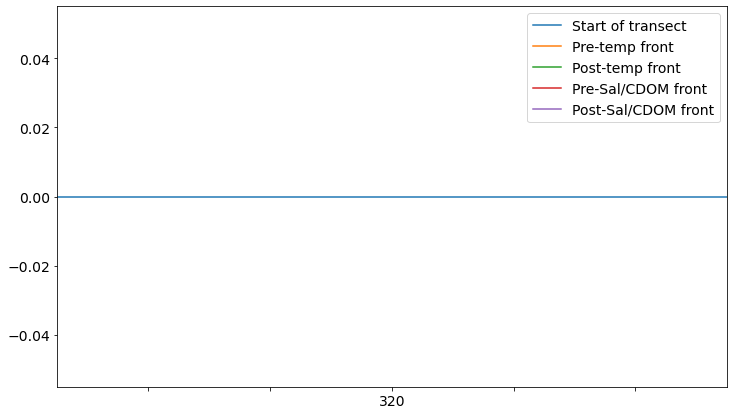

In [45]:
fig,ax = plt.subplots(figsize=(12,7))
corrected_specs.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2].plot(label='Start of transect')

corrected_specs.loc['2021-08-27 16:37:00':'2021-08-27 16:43:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-temp front')
corrected_specs.loc['2021-08-27 16:48:00':'2021-08-27 16:53:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-temp front')
corrected_specs.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-Sal/CDOM front')
corrected_specs.loc['2021-08-27 17:23:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-Sal/CDOM front')

ax.axhline(0)

ax.legend()
# plt.savefig('radiometry_spectra.png')


In [ ]:
16:20-16:30, pelgic side of front, 16:53-16:56 at front, 17:15-17:20 coastal side of front before secondary front, 17:40-17:45 coastal side of both fronts

In [106]:
corrected_specs.loc['2021-08-29 16:20:00':'2021-08-29 16:25:00'].median(numeric_only=True).iloc[:-5]

320    0.005382
321    0.005458
322    0.005472
323    0.005399
324    0.005313
         ...   
946   -0.000337
947   -0.000295
948   -0.000282
949   -0.000279
950   -0.000264
Length: 631, dtype: float64

In [117]:
corrected_specs.loc['2021-08-29 17:53:00':'2021-08-29 17:59:00']

Empty DataFrame
Columns: [320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, ...]
Index: []

[0 rows x 638 columns]

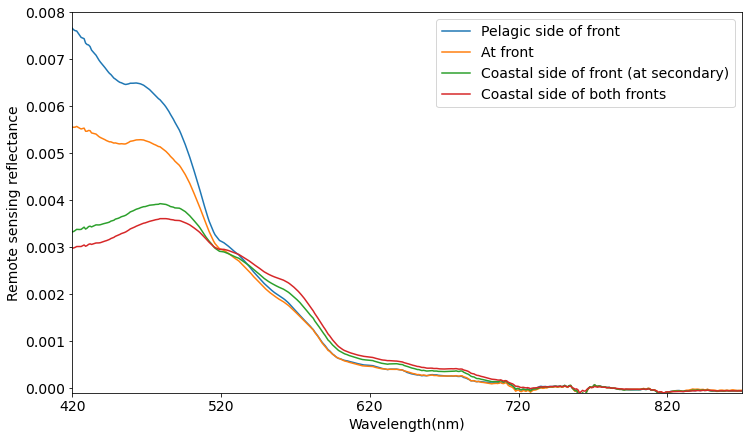

In [129]:
fig,ax = plt.subplots(figsize=(12,7))
corrected_specs.loc['2021-08-29 16:20:00':'2021-08-29 16:25:00'].median(numeric_only=True).iloc[:-5].plot(label='Pelagic side of front')
corrected_specs.loc['2021-08-29 16:53:00':'2021-08-29 16:56:00'].median(numeric_only=True).iloc[:-5].plot(label='At front')
corrected_specs.loc['2021-08-29 17:15:00':'2021-08-29 17:20:00'].median(numeric_only=True).iloc[:-5].plot(label='Coastal side of front (at secondary)')
corrected_specs.loc['2021-08-29 17:40:00':'2021-08-29 17:45:00'].median(numeric_only=True).iloc[:-5].plot(label='Coastal side of both fronts')

# ax.axhline(0)
ax.set_xlim(100,550)
ax.set_ylim(-0.0001,0.008)
ax.set_xlabel('Wavelength(nm)')
ax.set_ylabel('Remote sensing reflectance')

ax.legend()
plt.savefig('figs/aug2916_radiometry_spectra.png')


In [229]:
trios_subset[kmeans.labels_==0].iloc[:,:-7].values.T.mean(axis=1).shape

(631,)

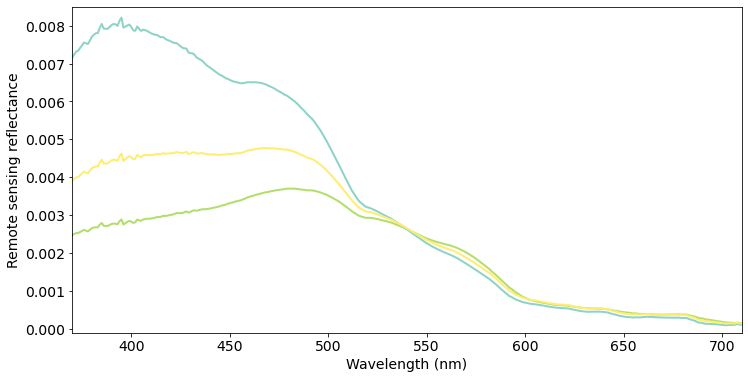

In [238]:
color_list = plt.cm.Set3(np.linspace(0, 1, 3))
color_list

fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlim(370,710)
ax.set_ylim(-0.0001,0.0085)
# ax.axvline(120, c='k', ls='--')
# ax.axvline(535-125, c='k', ls='--')
# ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==0].iloc[:,:-7].values.T,c=color_list[1], alpha=.01)
# ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==1].iloc[:,:-7].values.T,c=color_list[0], alpha=.01)
# ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==2].iloc[:,:-7].values.T,c=color_list[2], alpha=.01)

ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==0].iloc[:,:-7].values.T.mean(axis=1),c=color_list[1], alpha=1, lw=2)
ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==1].iloc[:,:-7].values.T.mean(axis=1),c=color_list[0], alpha=1, lw=2)
ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==2].iloc[:,:-7].values.T.mean(axis=1),c=color_list[2], alpha=1, lw=2)

# trios_subset[kmeans.labels_==0].iloc[:,:-8].plot(label='Pelagic side of front', ax=ax, c=color_list[1], lw=3)
# trios_subset[kmeans.labels_==1].median(numeric_only=True).iloc[:-5].plot(label='Pelagic side of front', ax=ax, c=color_list[0], lw=3)
# trios_subset[kmeans.labels_==2].median(numeric_only=True).iloc[:-5].plot(label='Pelagic side of front', ax=ax, c=color_list[2], lw=3)

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Remote sensing reflectance')

fig.savefig('figs/aug2916_trios_clusters_spectra.png',dpi=300)

In [243]:
trios_subset['cluster'] = kmeans.labels_

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [245]:
trios_subset.to_csv('trios_clusters_spectra.csv')

In [242]:
trios_subset.shape

(344, 638)

In [46]:
lats = []
lons = []
sals = []
temps = []
for i in range(len(corrected_specs)):
    row = df.iloc[df.index.get_loc(pd.to_datetime(corrected_specs.iloc[i].TimeStamp) + timedelta(hours=4), method='nearest')]
    lats.append(row.lat)
    lons.append(row.lon)
    sals.append(row['TSG--sal'])
    temps.append(row['TSG--temp-SBE38'])

In [47]:
corrected_specs['lat'] = lats
corrected_specs['lon'] = lons
corrected_specs['sal'] = sals
corrected_specs['temp'] = temps

In [48]:
trios_gdf = gpd.GeoDataFrame(
    corrected_specs, geometry=gpd.points_from_xy(corrected_specs.lon, corrected_specs.lat))

<AxesSubplot:>

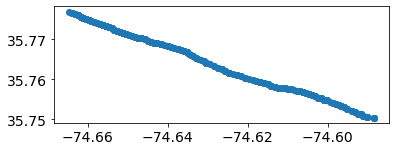

In [49]:
trios_gdf.plot()

In [50]:
trios_gdf.columns

Index(['320', '321', '322', '323', '324', '325', '326', '327', '328', '329',
       ...
       '948', '949', '950', 'chla_oci', 'TimeStamp', 'lat', 'lon', 'sal',
       'temp', 'geometry'],
      dtype='object', length=638)

In [51]:
chlci = trios_gdf.chla_oci.values

In [52]:
trios_gdf.iloc[:,1:-7]

321       322       323       324       325  \
2021-08-29 16:15:10  0.005342  0.005383  0.005333  0.005271  0.005224   
2021-08-29 16:15:20  0.005442  0.005458  0.005385  0.005306  0.005246   
2021-08-29 16:15:30  0.005799  0.005783  0.005705  0.005626  0.005566   
2021-08-29 16:15:40  0.005119  0.005142  0.005082  0.005014  0.004962   
2021-08-29 16:15:50  0.005650  0.005663  0.005593  0.005512  0.005448   
...                       ...       ...       ...       ...       ...   
2021-08-29 17:50:50  0.002661  0.002665  0.002617  0.002556  0.002509   
2021-08-29 17:51:00  0.002705  0.002704  0.002660  0.002607  0.002566   
2021-08-29 17:51:30  0.002004  0.002005  0.001965  0.001910  0.001868   
2021-08-29 17:51:40  0.001947  0.001940  0.001903  0.001852  0.001812   
2021-08-29 17:52:00  0.003927  0.003931  0.003873  0.003800  0.003741   

                          326       327       328       329       330  ...  \
2021-08-29 16:15:10  0.005256  0.005184  0.005047  0.005116  0.005195  ...   
2021-08-29 16:15:20  0.005269  0.005190  0.005048  0.005126  0.005227  ...   
2021-08-29 16:15:30  0.005592  0.005506  0.005350  0.005413  0.005506  ...   
2021-08-29 16:15:40  0.004985  0.004908  0.004768  0.004834  0.004930  ...   
2021-08-29 16:15:50  0.005473  0.005402  0.005266  0.005329  0.005418  ...   
...                       ...       ...       ...       ...       ...  ...   
2021-08-29 17:50:50  0.002511  0.002439  0.002323  0.002358  0.002402  ...   
2021-08-29 17:51:00  0.002573  0.002503  0.002389  0.002424  0.002466  ...   
2021-08-29 17:51:30  0.001874  0.001801  0.001684  0.001718  0.001763  ...   
2021-08-29 17:51:40  0.001813  0.001745  0.001639  0.001675  0.001718  ...   
2021-08-29 17:52:00  0.003741  0.003657  0.003523  0.003552  0.003590  ...   

                          941       942       943       944       945  \
2021-08-29 16:15:10 -0.000420 -0.000468 -0.000381 -0.000260 -0.000141   
2021-08-29 16:15:20 -0.000469 -0.000600 -0.000486 -0.000381 -0.000276   
2021-08-29 16:15:30 -0.000533 -0.000585 -0.000709 -0.000770 -0.000830   
2021-08-29 16:15:40 -0.000616 -0.000581 -0.000557 -0.000587 -0.000618   
2021-08-29 16:15:50 -0.001112 -0.001083 -0.000967 -0.000850 -0.000734   
...                       ...       ...       ...       ...       ...   
2021-08-29 17:50:50 -0.000287 -0.000253 -0.000283 -0.000298 -0.000314   
2021-08-29 17:51:00 -0.000282 -0.000342 -0.000362 -0.000335 -0.000305   
2021-08-29 17:51:30 -0.000152 -0.000184 -0.000176 -0.000126 -0.000076   
2021-08-29 17:51:40 -0.000132 -0.000139 -0.000095 -0.000079 -0.000066   
2021-08-29 17:52:00 -0.000412 -0.000416 -0.000482 -0.000547 -0.000610   

                          946       947       948       949       950  
2021-08-29 16:15:10 -0.000235 -0.000450 -0.000701 -0.000786 -0.000749  
2021-08-29 16:15:20 -0.000403 -0.000530 -0.000644 -0.000569 -0.000461  
2021-08-29 16:15:30 -0.000726 -0.000702 -0.000719 -0.000709 -0.000649  
2021-08-29 16:15:40 -0.000626 -0.000626 -0.000623 -0.000551 -0.000451  
2021-08-29 16:15:50 -0.000690 -0.000659 -0.000629 -0.000651 -0.000712  
...                       ...       ...       ...       ...       ...  
2021-08-29 17:50:50 -0.000306 -0.000312 -0.000325 -0.000320 -0.000317  
2021-08-29 17:51:00 -0.000286 -0.000274 -0.000263 -0.000257 -0.000262  
2021-08-29 17:51:30 -0.000028 -0.000013 -0.000011 -0.000038 -0.000071  
2021-08-29 17:51:40 -0.000023  0.000010  0.000035 -0.000018 -0.000100  
2021-08-29 17:52:00 -0.000582 -0.000555 -0.000535 -0.000498 -0.000461  

[344 rows x 630 columns]

In [53]:
chlci[chlci>.5] = .5

(0.1, 0.4)

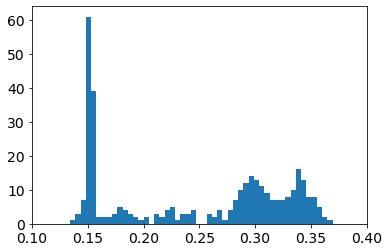

In [54]:
plt.hist(chlci, bins=50)
plt.xlim(0.1,.4)

Run some clustering

In [55]:
trios_gdf.columns[1:-7]

Index(['321', '322', '323', '324', '325', '326', '327', '328', '329', '330',
       ...
       '941', '942', '943', '944', '945', '946', '947', '948', '949', '950'],
      dtype='object', length=630)

In [56]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(trios_gdf.values[:,1:-7])

In [57]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32), array([ 18,  95, 109,  38,  84]))

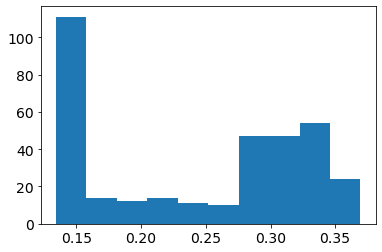

In [58]:
plt.hist(trios_gdf.chla_oci)
plt.show()

Text(0.5, 1.0, 'August 27th Trios Radiometer based Chla')

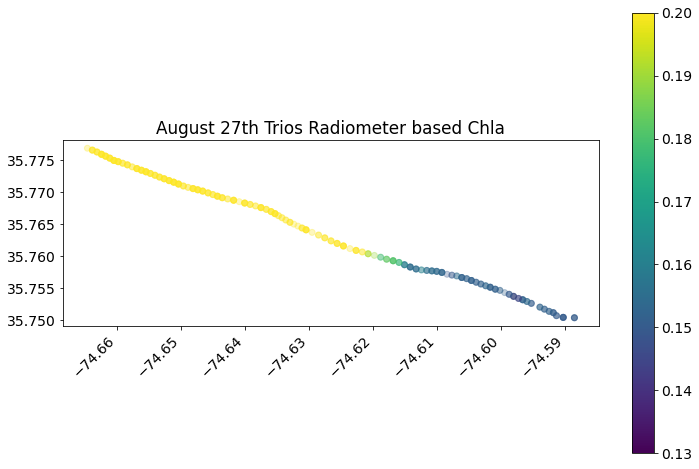

In [59]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(trios_gdf.values[:,1:-7])
fig, ax = plt.subplots(figsize=(12,9))
sc = trios_gdf.plot('chla_oci', ax=ax, vmin=.13,vmax=.20, cmap='viridis', alpha=0.3, label='CI Chla', legend=True)
# ss = ax.scatter(trios_gdf.lon, trios_gdf.lat, c=trios_gdf.chl, s=100)
# fig.colorbar(sc,ax=ax)
# fig.colorbar(sc, ax=ax)
fig.autofmt_xdate(rotation=45)
ax.set_title('August 27th Trios Radiometer based Chla')
# fig.savefig('trios_radiometers_chlaci.png')

<AxesSubplot:>

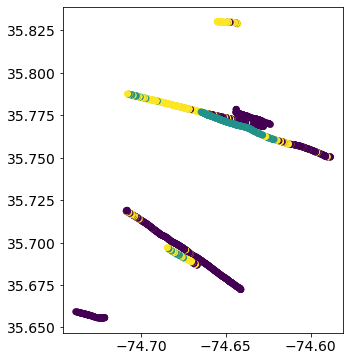

In [134]:
fig, ax = plt.subplots(figsize=(8,6))
trios_gdf.plot(c=kmeans.labels_,ax=ax)

In [135]:
trios_gdf_transect = trios_gdf#.loc['2021-08-27 16:15:00':'2021-08-27 17:30:00']

In [219]:
x = trios_gdf_transect.rolling(window=6).mean().values[:,1:-7]

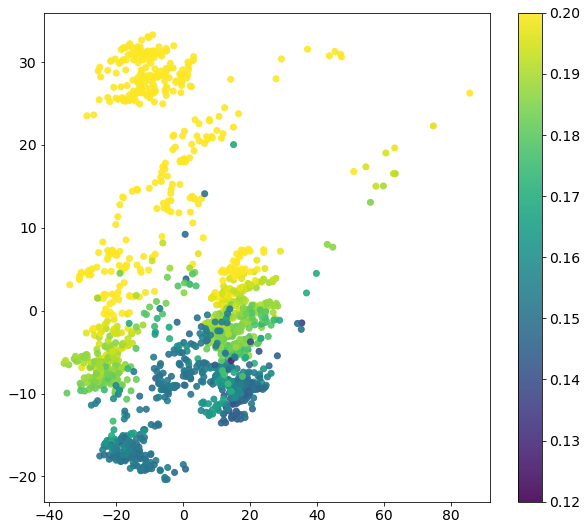

In [220]:
x = trios_gdf_transect.rolling(window=6).mean().values[:,1:-7]
x = x[12:,:]
from sklearn.preprocessing import StandardScaler
# Standardizing the features
x = StandardScaler().fit_transform(x)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(principalComponents[:,0], principalComponents[:,1], alpha=0.9, c=trios_gdf_transect['chla_oci'].iloc[12:], vmin=.12,vmax=.20, cmap='viridis', label='chla')
fig.colorbar(sc)

In [221]:
from sklearn.preprocessing import StandardScaler
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [222]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

In [140]:
principalComponents.shape

(1544, 2)

<AxesSubplot:>

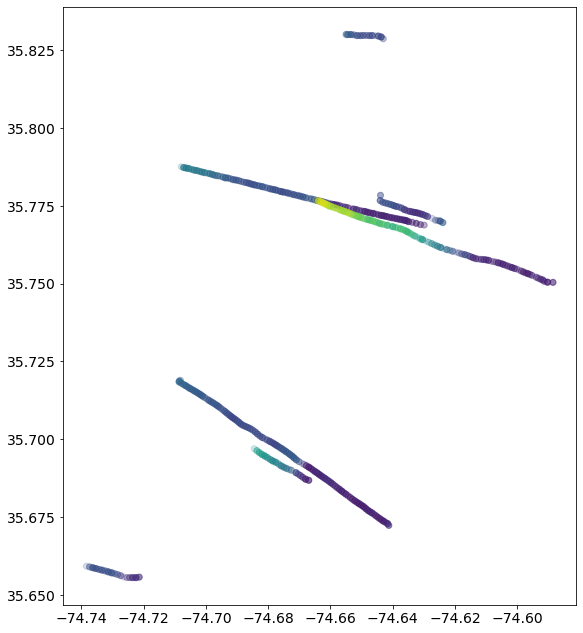

In [141]:
fig, ax = plt.subplots(figsize=(14,11))
trios_gdf_transect.iloc[12:].plot(c=trios_gdf_transect.iloc[12:].chla_oci,ax=ax, alpha=0.2, vmin=0.2, vmax=.24)
# fig.savefig('chla_transect.png')

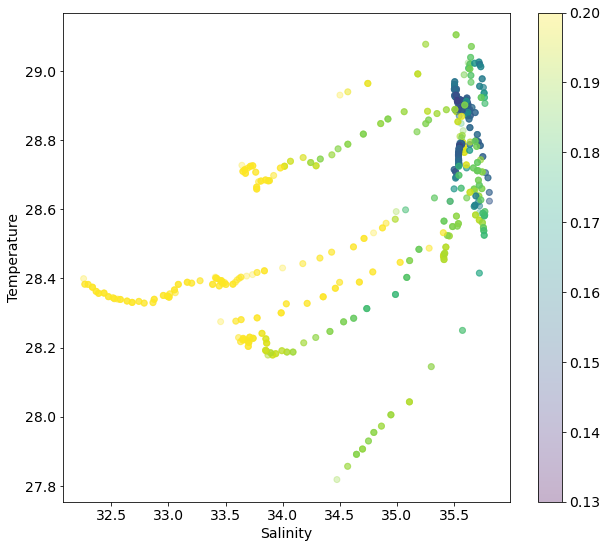

In [144]:
fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(trios_gdf_transect['sal'].iloc[12:], trios_gdf_transect['temp'].iloc[12:], alpha=0.3, c=trios_gdf_transect['chla_oci'].iloc[12:], vmin=.13,vmax=.20, cmap='viridis', label='chla')

ax.set_xlabel("Salinity")
ax.set_ylabel("Temperature")


fig.colorbar(sc)
# ax.set_ylim(-3,2)
# ax.set_xlim(-6,8)
# fig.savefig('pca_transect.png')

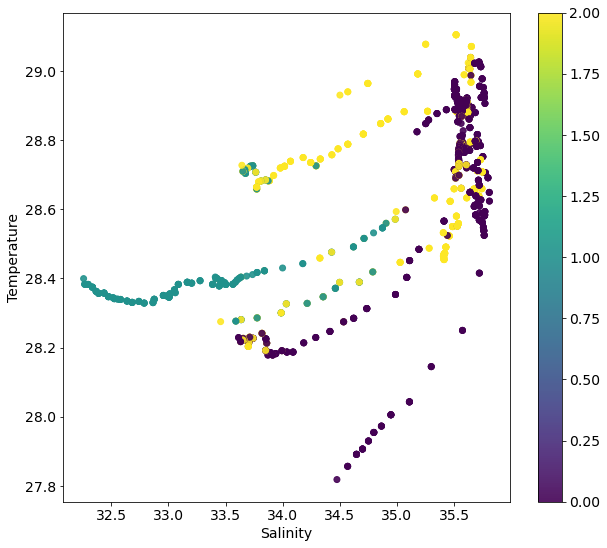

In [145]:
fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(trios_gdf_transect['sal'].iloc[12:], trios_gdf_transect['temp'].iloc[12:], alpha=0.9, c=kmeans.labels_[12:], cmap='viridis', label='chla')

ax.set_xlabel("Salinity")
ax.set_ylabel("Temperature")


fig.colorbar(sc)
# ax.set_ylim(-3,2)
# ax.set_xlim(-6,8)
# fig.savefig('pca_transect.png')

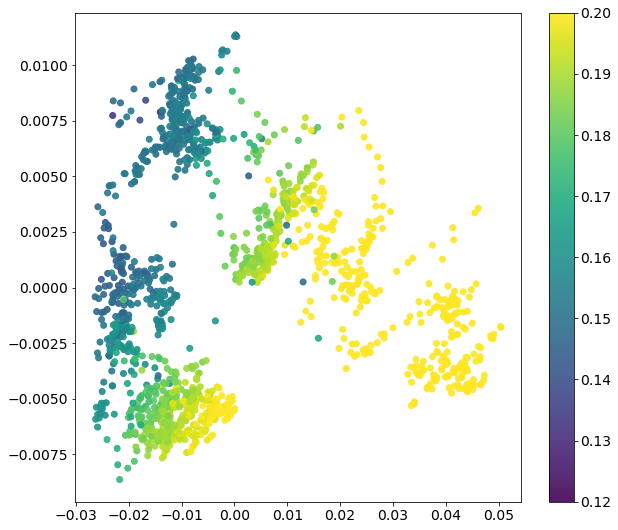

In [190]:
fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(principalComponents[:,0], principalComponents[:,1], alpha=0.9, c=trios_gdf_transect['chla_oci'].iloc[12:], vmin=.12,vmax=.20, cmap='viridis', label='chla')
fig.colorbar(sc)
# ax.set_ylim(-3,2)
# ax.set_xlim(-6,8)
# fig.savefig('pca_transect.png')

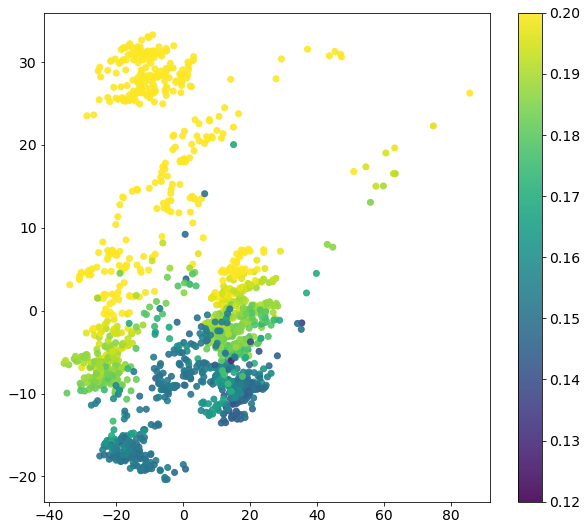

In [146]:
fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(principalComponents[:,0], principalComponents[:,1], alpha=0.9, c=trios_gdf_transect['chla_oci'].iloc[12:], vmin=.12,vmax=.20, cmap='viridis', label='chla')
fig.colorbar(sc)
# ax.set_ylim(-3,2)
# ax.set_xlim(-6,8)
# fig.savefig('pca_transect.png')

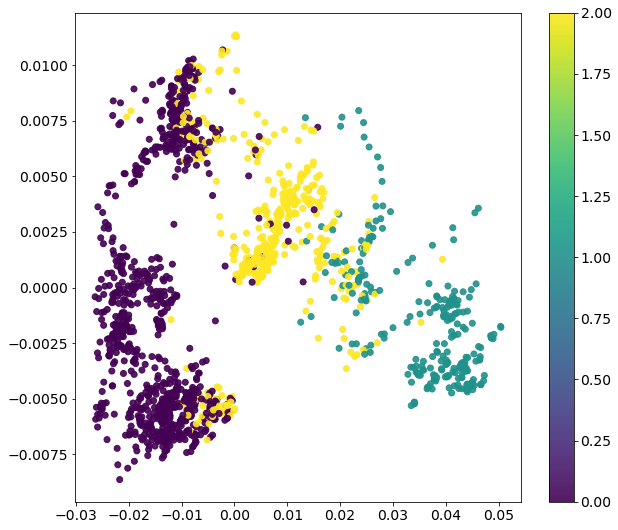

In [193]:
fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(principalComponents[:,0], principalComponents[:,1], alpha=0.9, c=kmeans.labels_[12:], cmap='viridis', label='chla')
fig.colorbar(sc)
# ax.set_ylim(-3,2)
# ax.set_xlim(-6,8)
# fig.savefig('pca_transect.png')

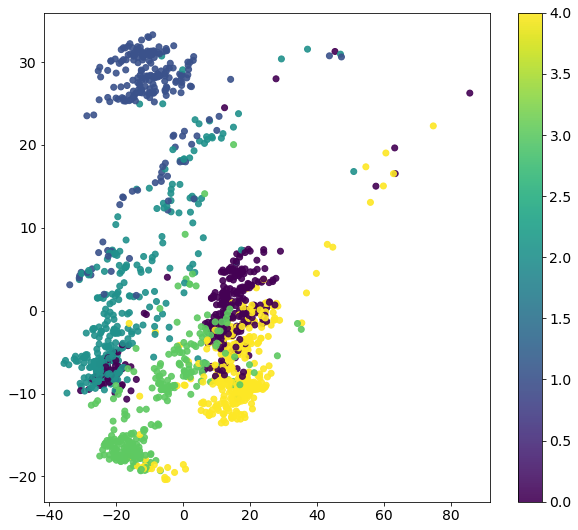

In [223]:
fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(principalComponents[:,0], principalComponents[:,1], alpha=0.9, c=kmeans.labels_[12:], cmap='viridis', label='chla')
fig.colorbar(sc)
# ax.set_ylim(-3,2)
# ax.set_xlim(-6,8)
# fig.savefig('pca_transect.png')

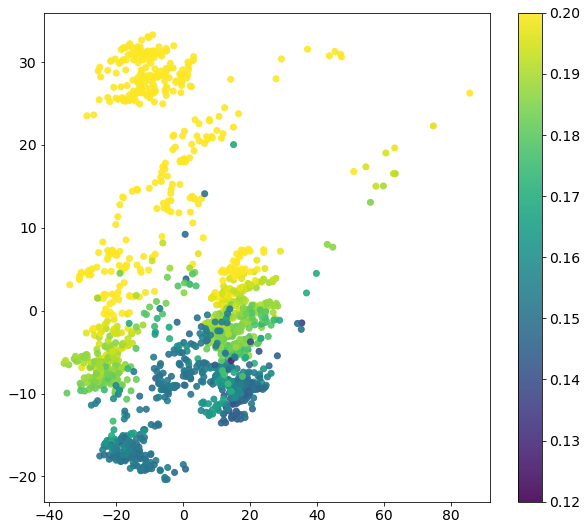

In [148]:
fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(principalComponents[:,0], principalComponents[:,1], alpha=0.9, c=trios_gdf_transect['chla_oci'].iloc[12:], vmin=.12,vmax=.20, cmap='viridis', label='chla')
fig.colorbar(sc)
# ax.set_ylim(-3,2)
# ax.set_xlim(-6,8)
# fig.savefig('pca_transect.png')

In [149]:
# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=5, random_state=0).fit(x)
# np.unique(kmeans.labels_, return_counts=True)

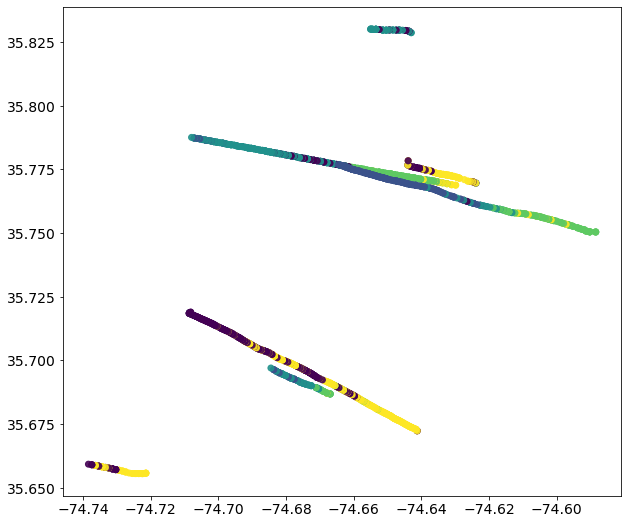

In [215]:
fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(trios_gdf_transect['lon'].iloc[12:], trios_gdf_transect['lat'].iloc[12:], alpha=0.9, c=kmeans.labels_[12:], cmap='viridis', label='chla')

ValueError: array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2,
       2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2,
       2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0,
       2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0,
       2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2], dtype=int32) is not a valid value for color

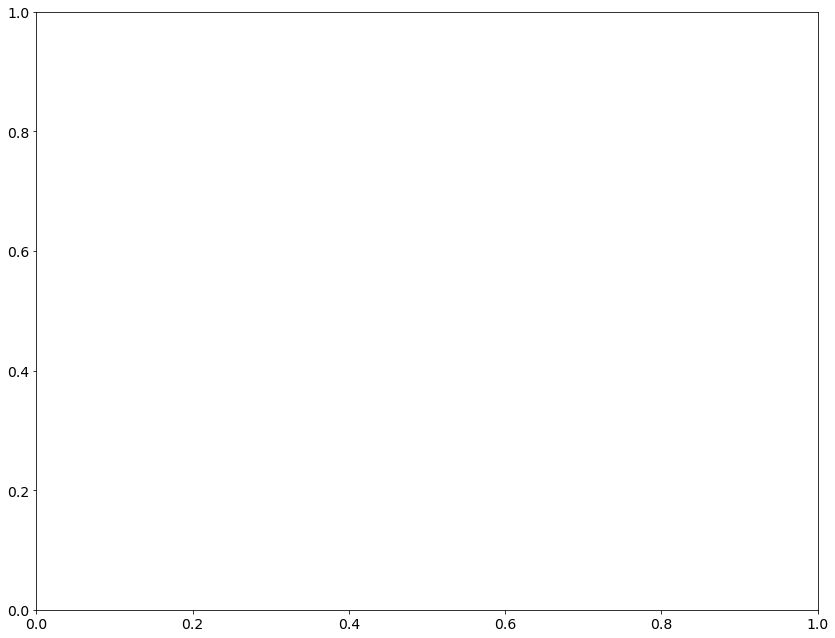

In [209]:
fig, ax = plt.subplots(figsize=(14,11))
ax.plot(trios_gdf_transect.iloc[12:].lon,trios_gdf_transect.iloc[12:].lon,c=kmeans.labels_,ax=ax, alpha=0.2, cmap='Set1')`a


In [151]:
len(x), len(kmeans.labels_[12:])

(1544, 1544)

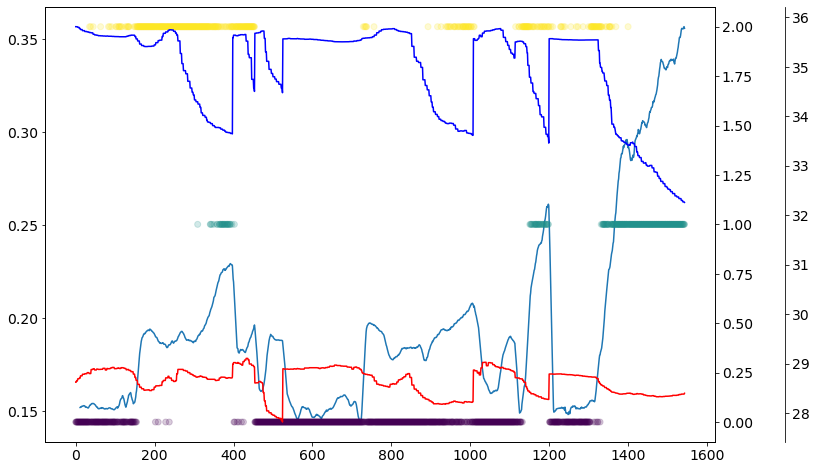

In [152]:
fig, ax  =plt.subplots(figsize=(12,8))
ax.plot(np.arange(0,len(x)),trios_gdf_transect.chla_oci.iloc[12:].rolling(window=12).mean())

ax2=ax.twinx()
ax2.scatter(np.arange(0,len(x)), kmeans.labels_[12:], alpha=0.2, c=kmeans.labels_[12:])

ax3 = ax.twinx()
ax3.plot(np.arange(0,len(x)),trios_gdf_transect['sal'].iloc[12:], color='blue')
ax3.plot(np.arange(0,len(x)),trios_gdf_transect['temp'].iloc[12:], color='red')
ax3.spines['right'].set_position(('outward', 70))

# fig.savefig('cluster_chla.png')